# Document Question Answering with Langchain

Large Language Models (LLMs) are pretty good at generating text from vast amounts of knowledge they are trained on during the training process. However, they are frozen in time - i.e. they don't have access to any information that was not available during training - either the information did not exist back in time or it was not part of the training dataset.

In this guide, we will build Document question answering application with [Langchain](https://python.langchain.com/en/latest/index.html) using [Retrieval Augmented Generation](https://blog.langchain.dev/tutorial-chatgpt-over-your-data/)  

The app will process a folder of PDF files, parse them, split them into chunks and index them in [Chroma](https://docs.trychroma.com/getting-started) DB. Then we can match an incoming user's query with these chunks using vector similarity. Then we can feed those matching chunks as context in addition to user's question to the LLM to get grounded answers


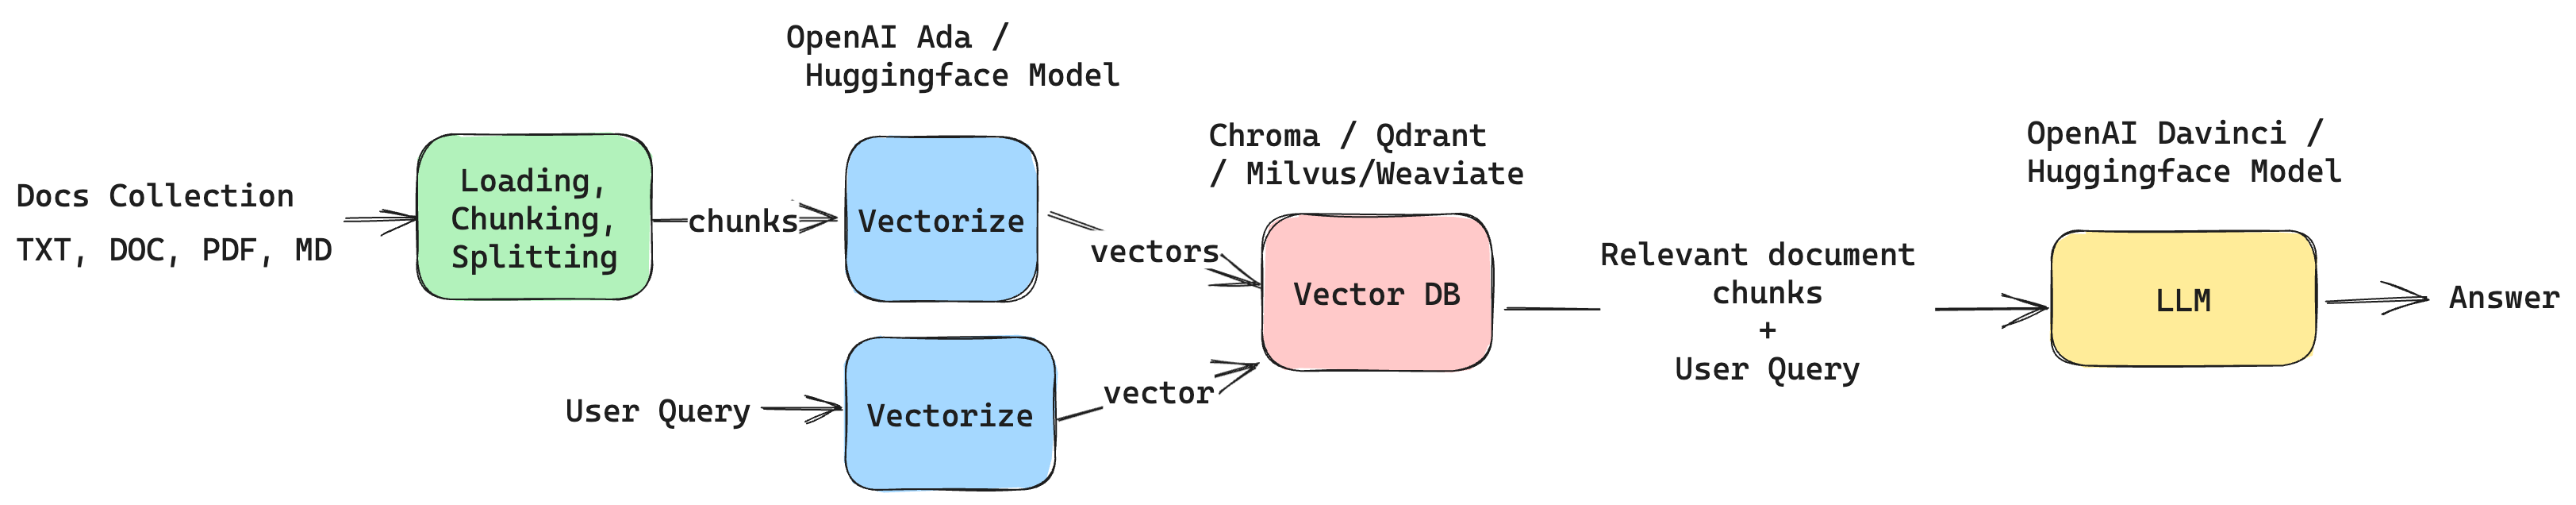

---

While this is a notebook to play around with Langchain and Retrieval Augmented Generation on your own, the [TrueFoundry Platform](https://www.truefoundry.com/llmops) can:

- Deploy most popular embedding models and large language models with a few clicks with most optimal settings
- Deploy databases like Qdrant, Weaviate, Milvus with a few clicks
- Interactive UI to manage documents, index them and chat with your documents
- Deploy your backend, frontend applications as well as Jobs
- Finetunine Large Language Models
- Autoscale your models and services with traffic patterns and schedule
- Save costs by mixing On-Demand and Spot Instances

## 1. Setting up dependencies

In [ ]:
!cat requirements.txt

In [ ]:
%pip install -r requirements.txt

In [ ]:
import nltk
nltk.download("punkt")

## Loading PDF files

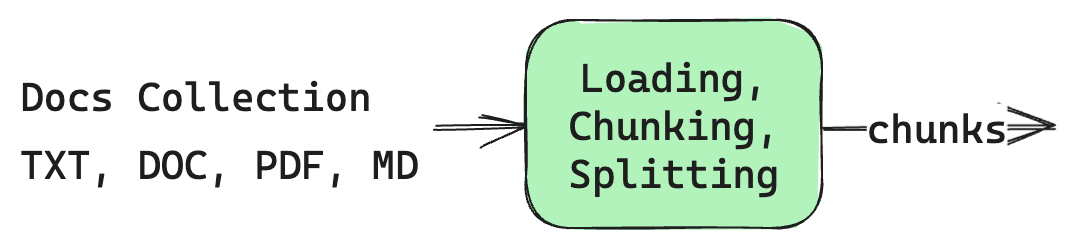

Here we will download a sample pdf from the internet and place it in the `data/` directory. You can bring your own files too.

In [ ]:
import urllib.request
data = [
    ("https://mlops.community/wp-content/uploads/2023/06/llm-survey-report.pdf", "llmops_report.pdf"),
    ("https://services.google.com/fh/files/misc/practitioners_guide_to_mlops_whitepaper.pdf", "google_mlops.pdf")
]
for url, filename in data:
    with urllib.request.urlopen(url) as read_f:
        with open(f"./data/{filename}", "wb") as write_f:
            write_f.write(read_f.read())

#### Parsing and Splitting

Here we use a very simple `pypdf` loader that can extract text from each page separately. Depending on your usecase you might want to use more sophisticated parsing tools which can also include running OCR on images and extracting tables

In [ ]:
import os
from langchain.document_loaders import PyPDFLoader

DATA_DIR = "./data"
all_pages = []
for filename in os.listdir(DATA_DIR):
    if not filename.startswith(".") and filename.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(DATA_DIR, filename))
        pages = loader.load_and_split()
        all_pages.extend(pages)
        
print("Total Pages:", len(all_pages))

In [ ]:
import uuid
from langchain.text_splitter import NLTKTextSplitter

CHUNK_SIZE = 750
CHUNK_OVERLAP = 150

splitter = NLTKTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
chunks = splitter.split_documents(all_pages)
for chunk in chunks:
    chunk.page_content = " ".join(chunk.page_content.split("\n"))

ids = []
for chunk in chunks:
    id_ = str(uuid.uuid5(uuid.NAMESPACE_DNS, chunk.page_content))
    ids.append(id_)
seen_ids = set()
unique_ids = []
unique_chunks = []
for id_, chunk in zip(ids, chunks):
    if id_ not in seen_ids:
        seen_ids.add(id_)
        unique_ids.append(id_)
        unique_chunks.append(chunk)
ids, chunks = unique_ids, unique_chunks
    
print(f"Made {len(chunks)} chunks")
print(chunks[20])

## 2. Embedding Documents
### Running a Embedding Model (This part is optional, you can use directly from LLM Gateway)

Next we will prepare a embedder that can vectorize the extracted chunks which we will index later

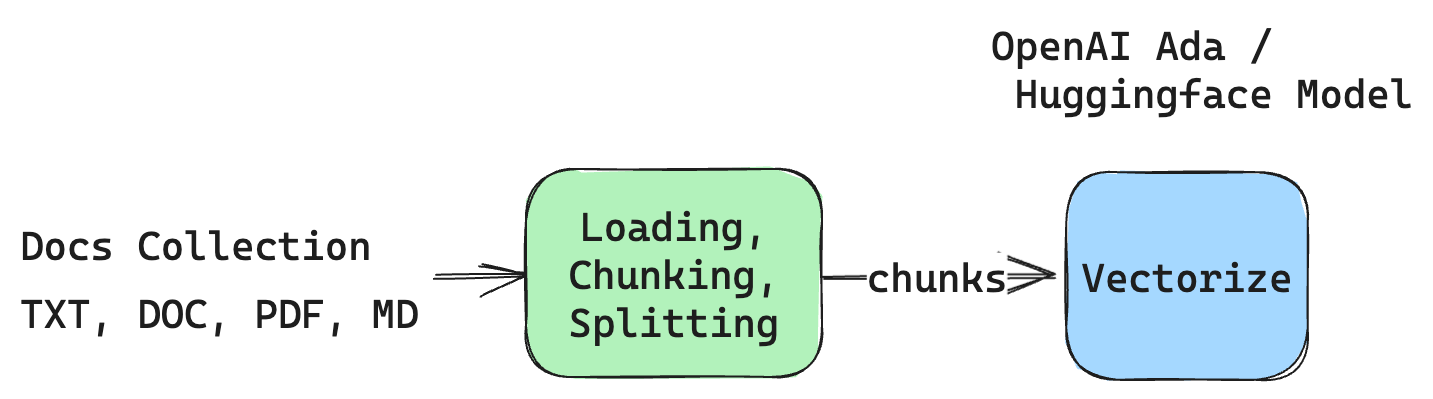

### Using Embedding Model from Model Catalogue
**Note:** In case you have resources and want to use an embedding model locally, see Appendix section

#### Deploying a Model

Let's Deploy a Embedding model from model catalogue. Navigate to Deployment > New Deployments, select `Model` in the left hand side. Now, select `Workspace` and `Embedding Model` to deploy.
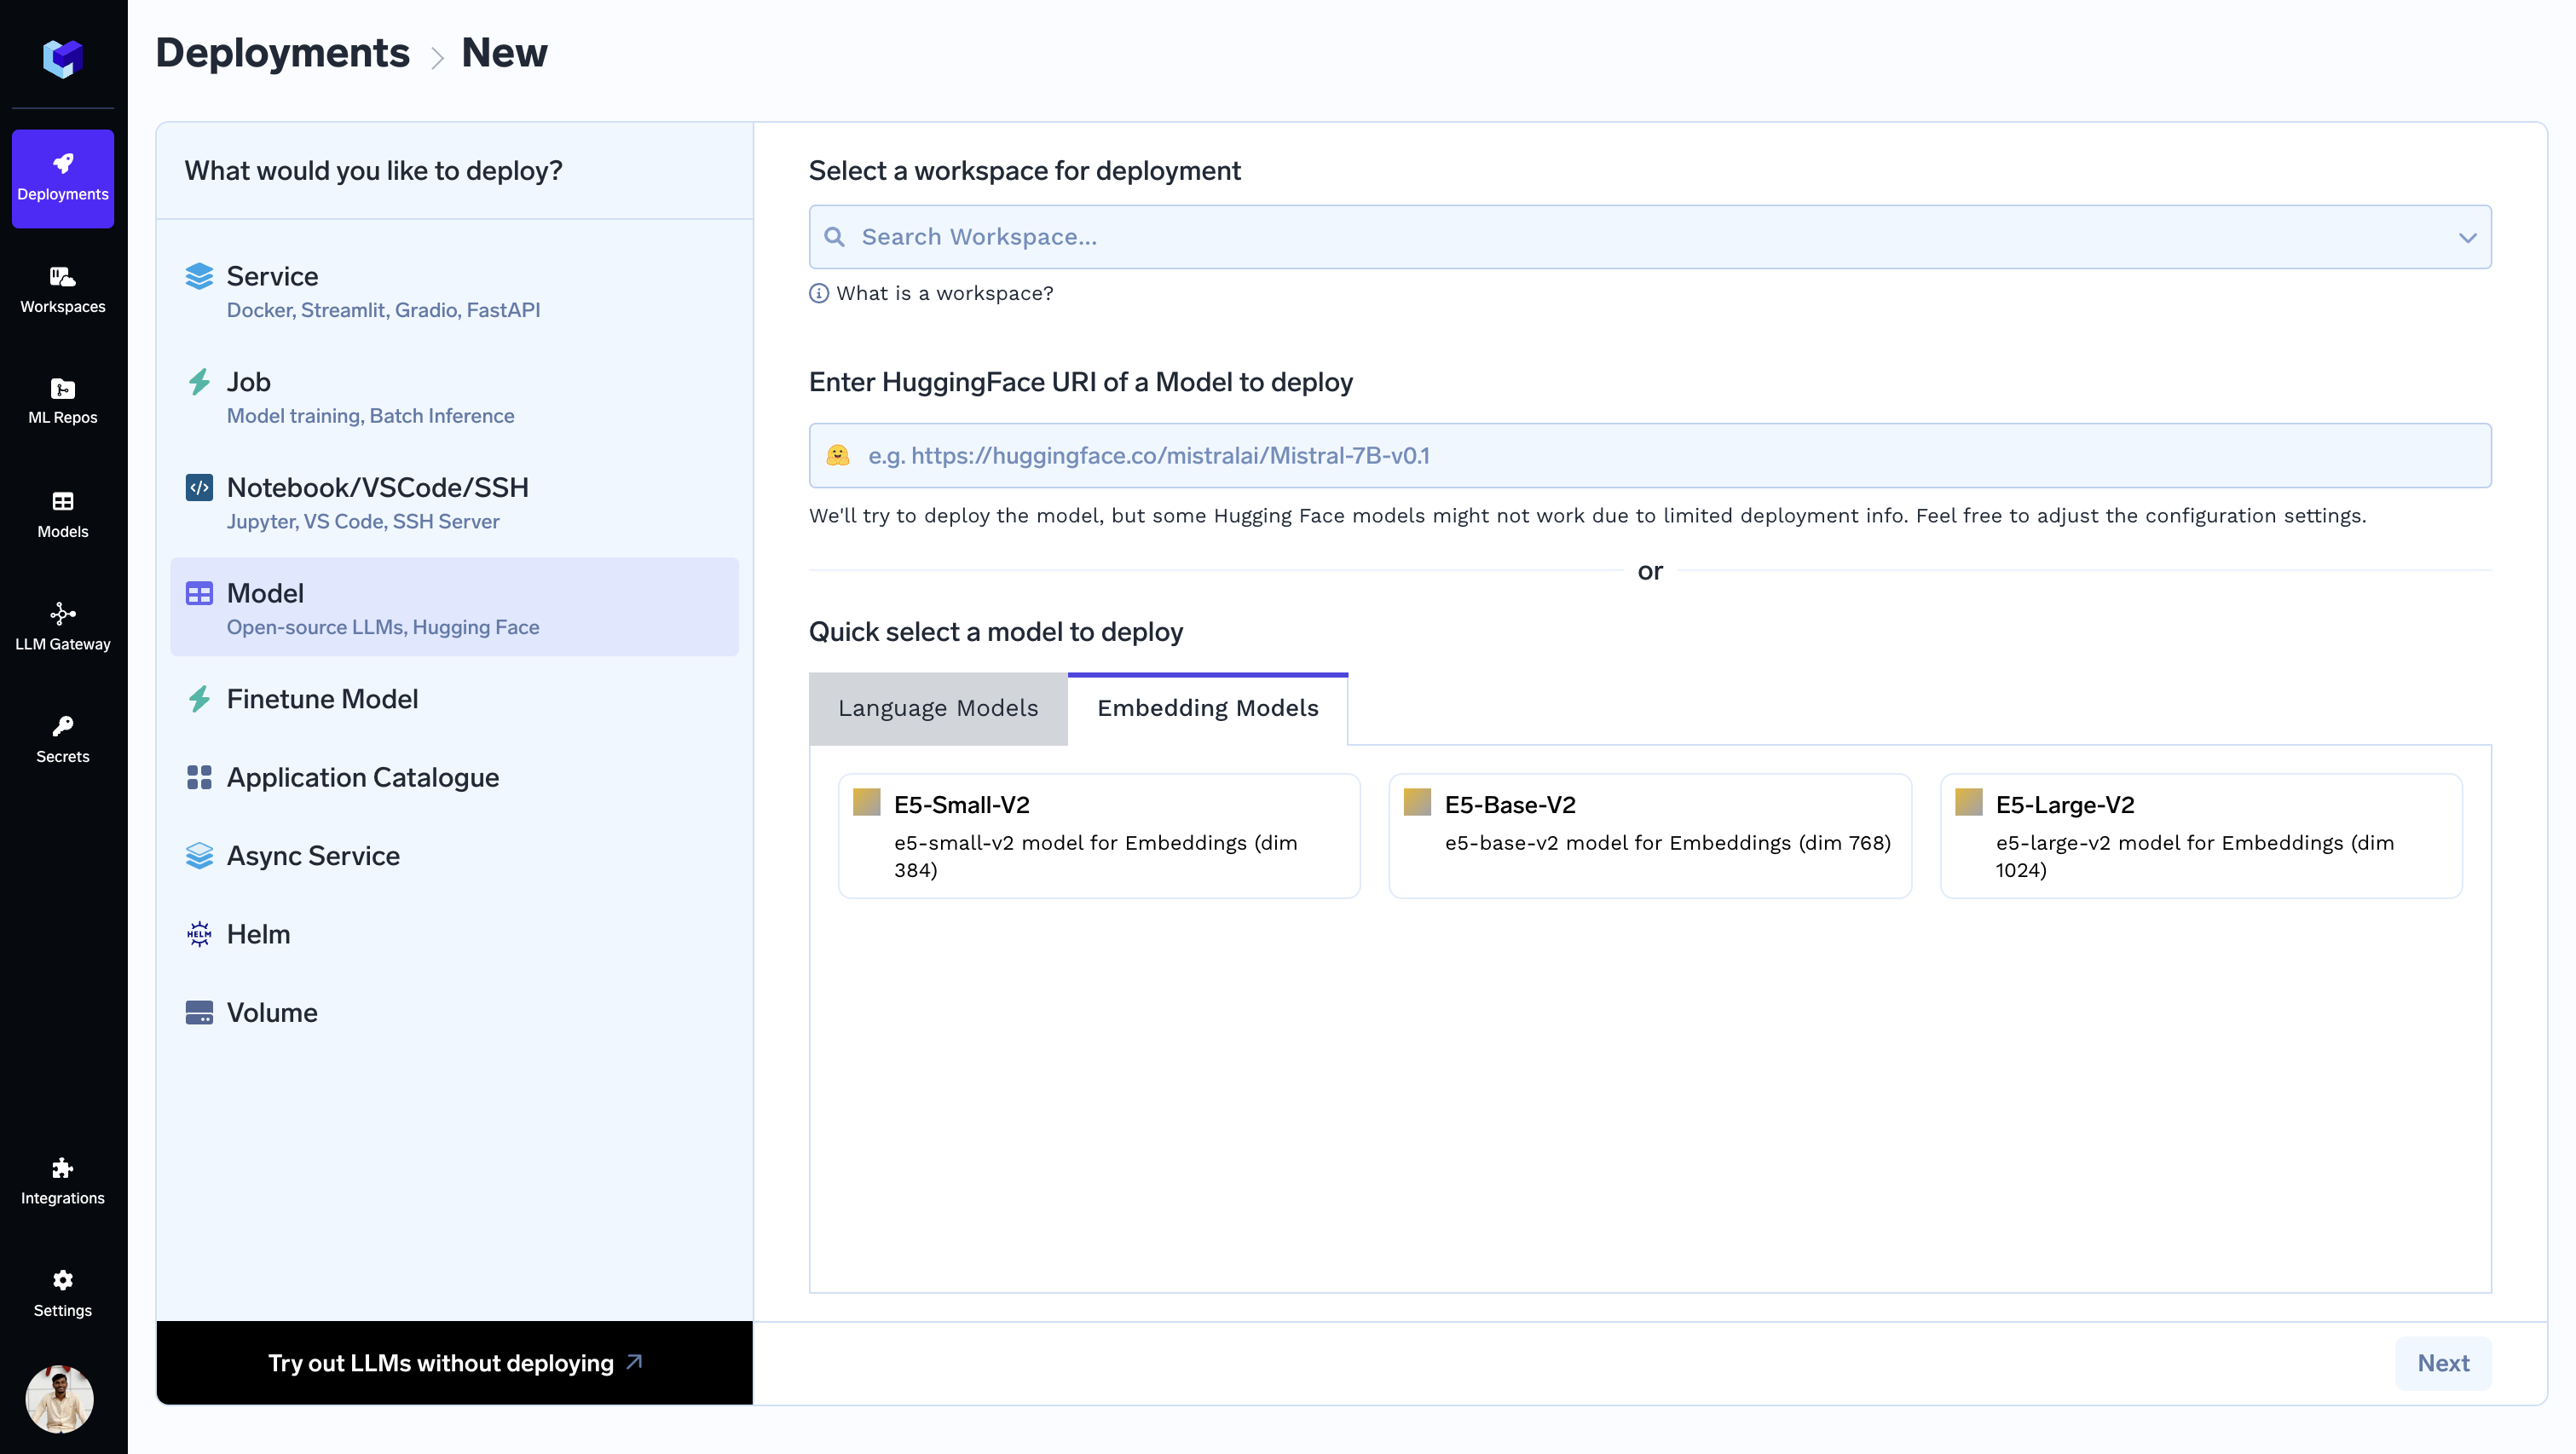


Select a infra configuration
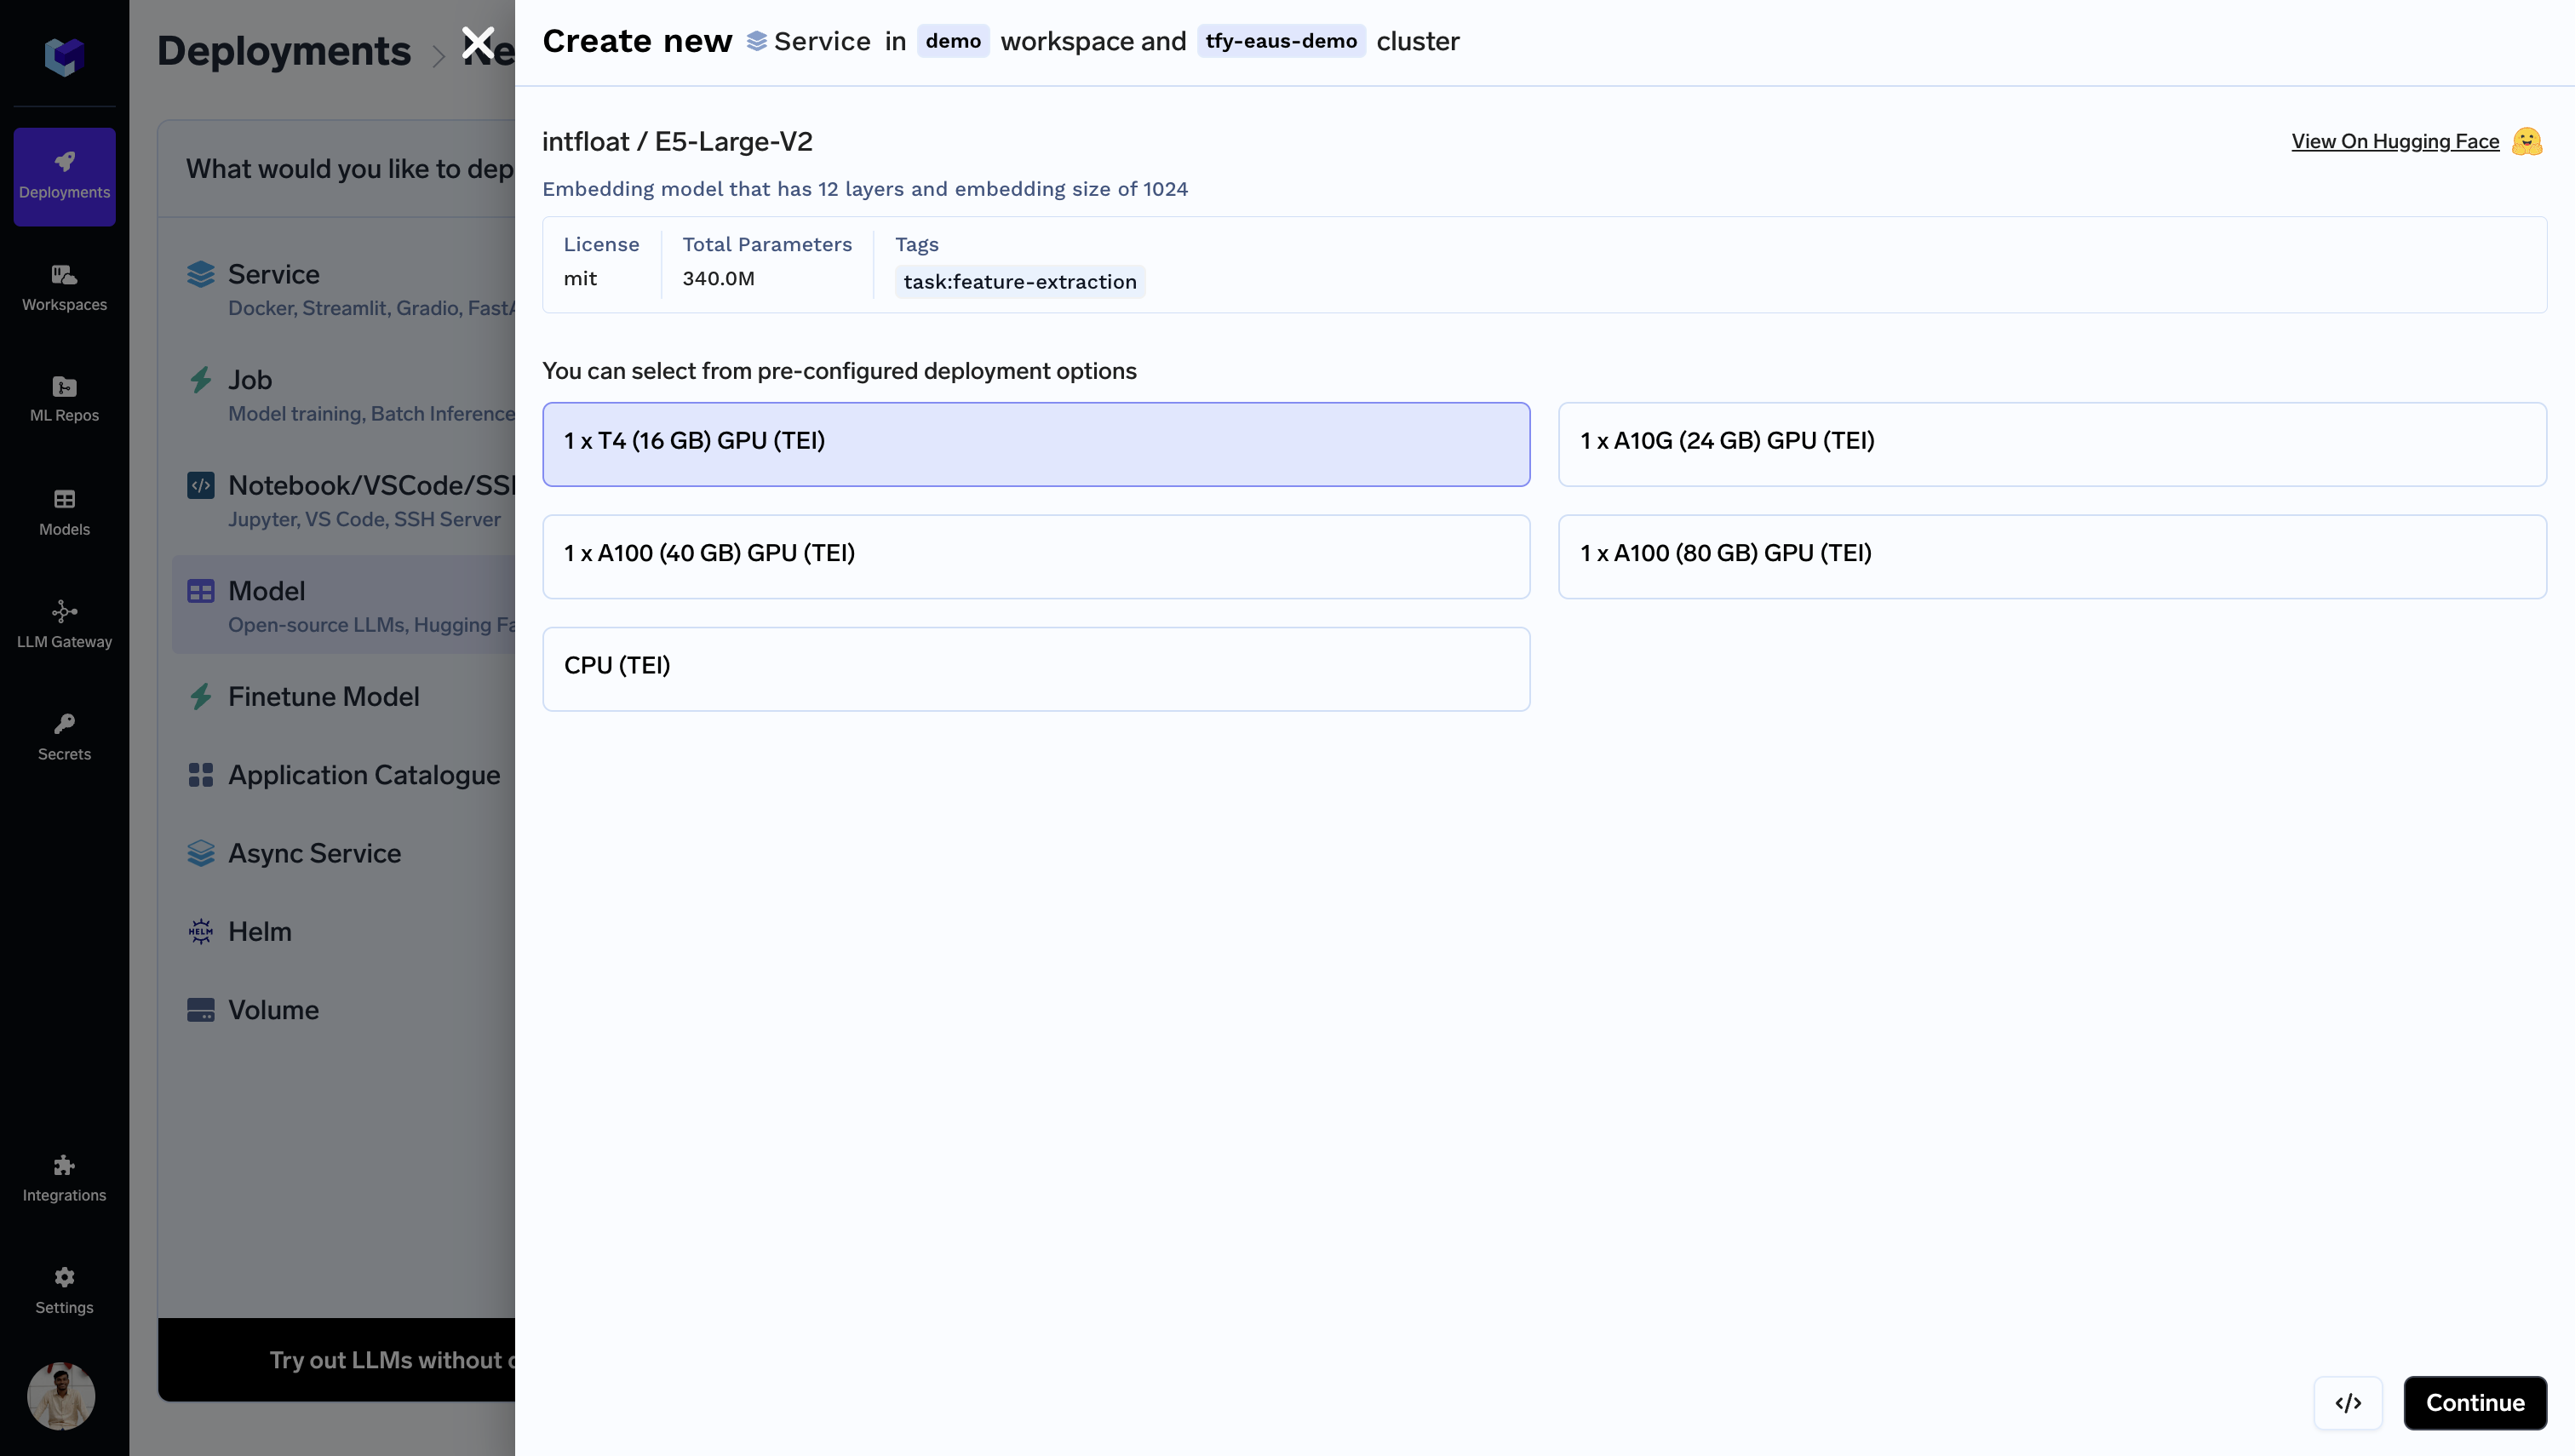
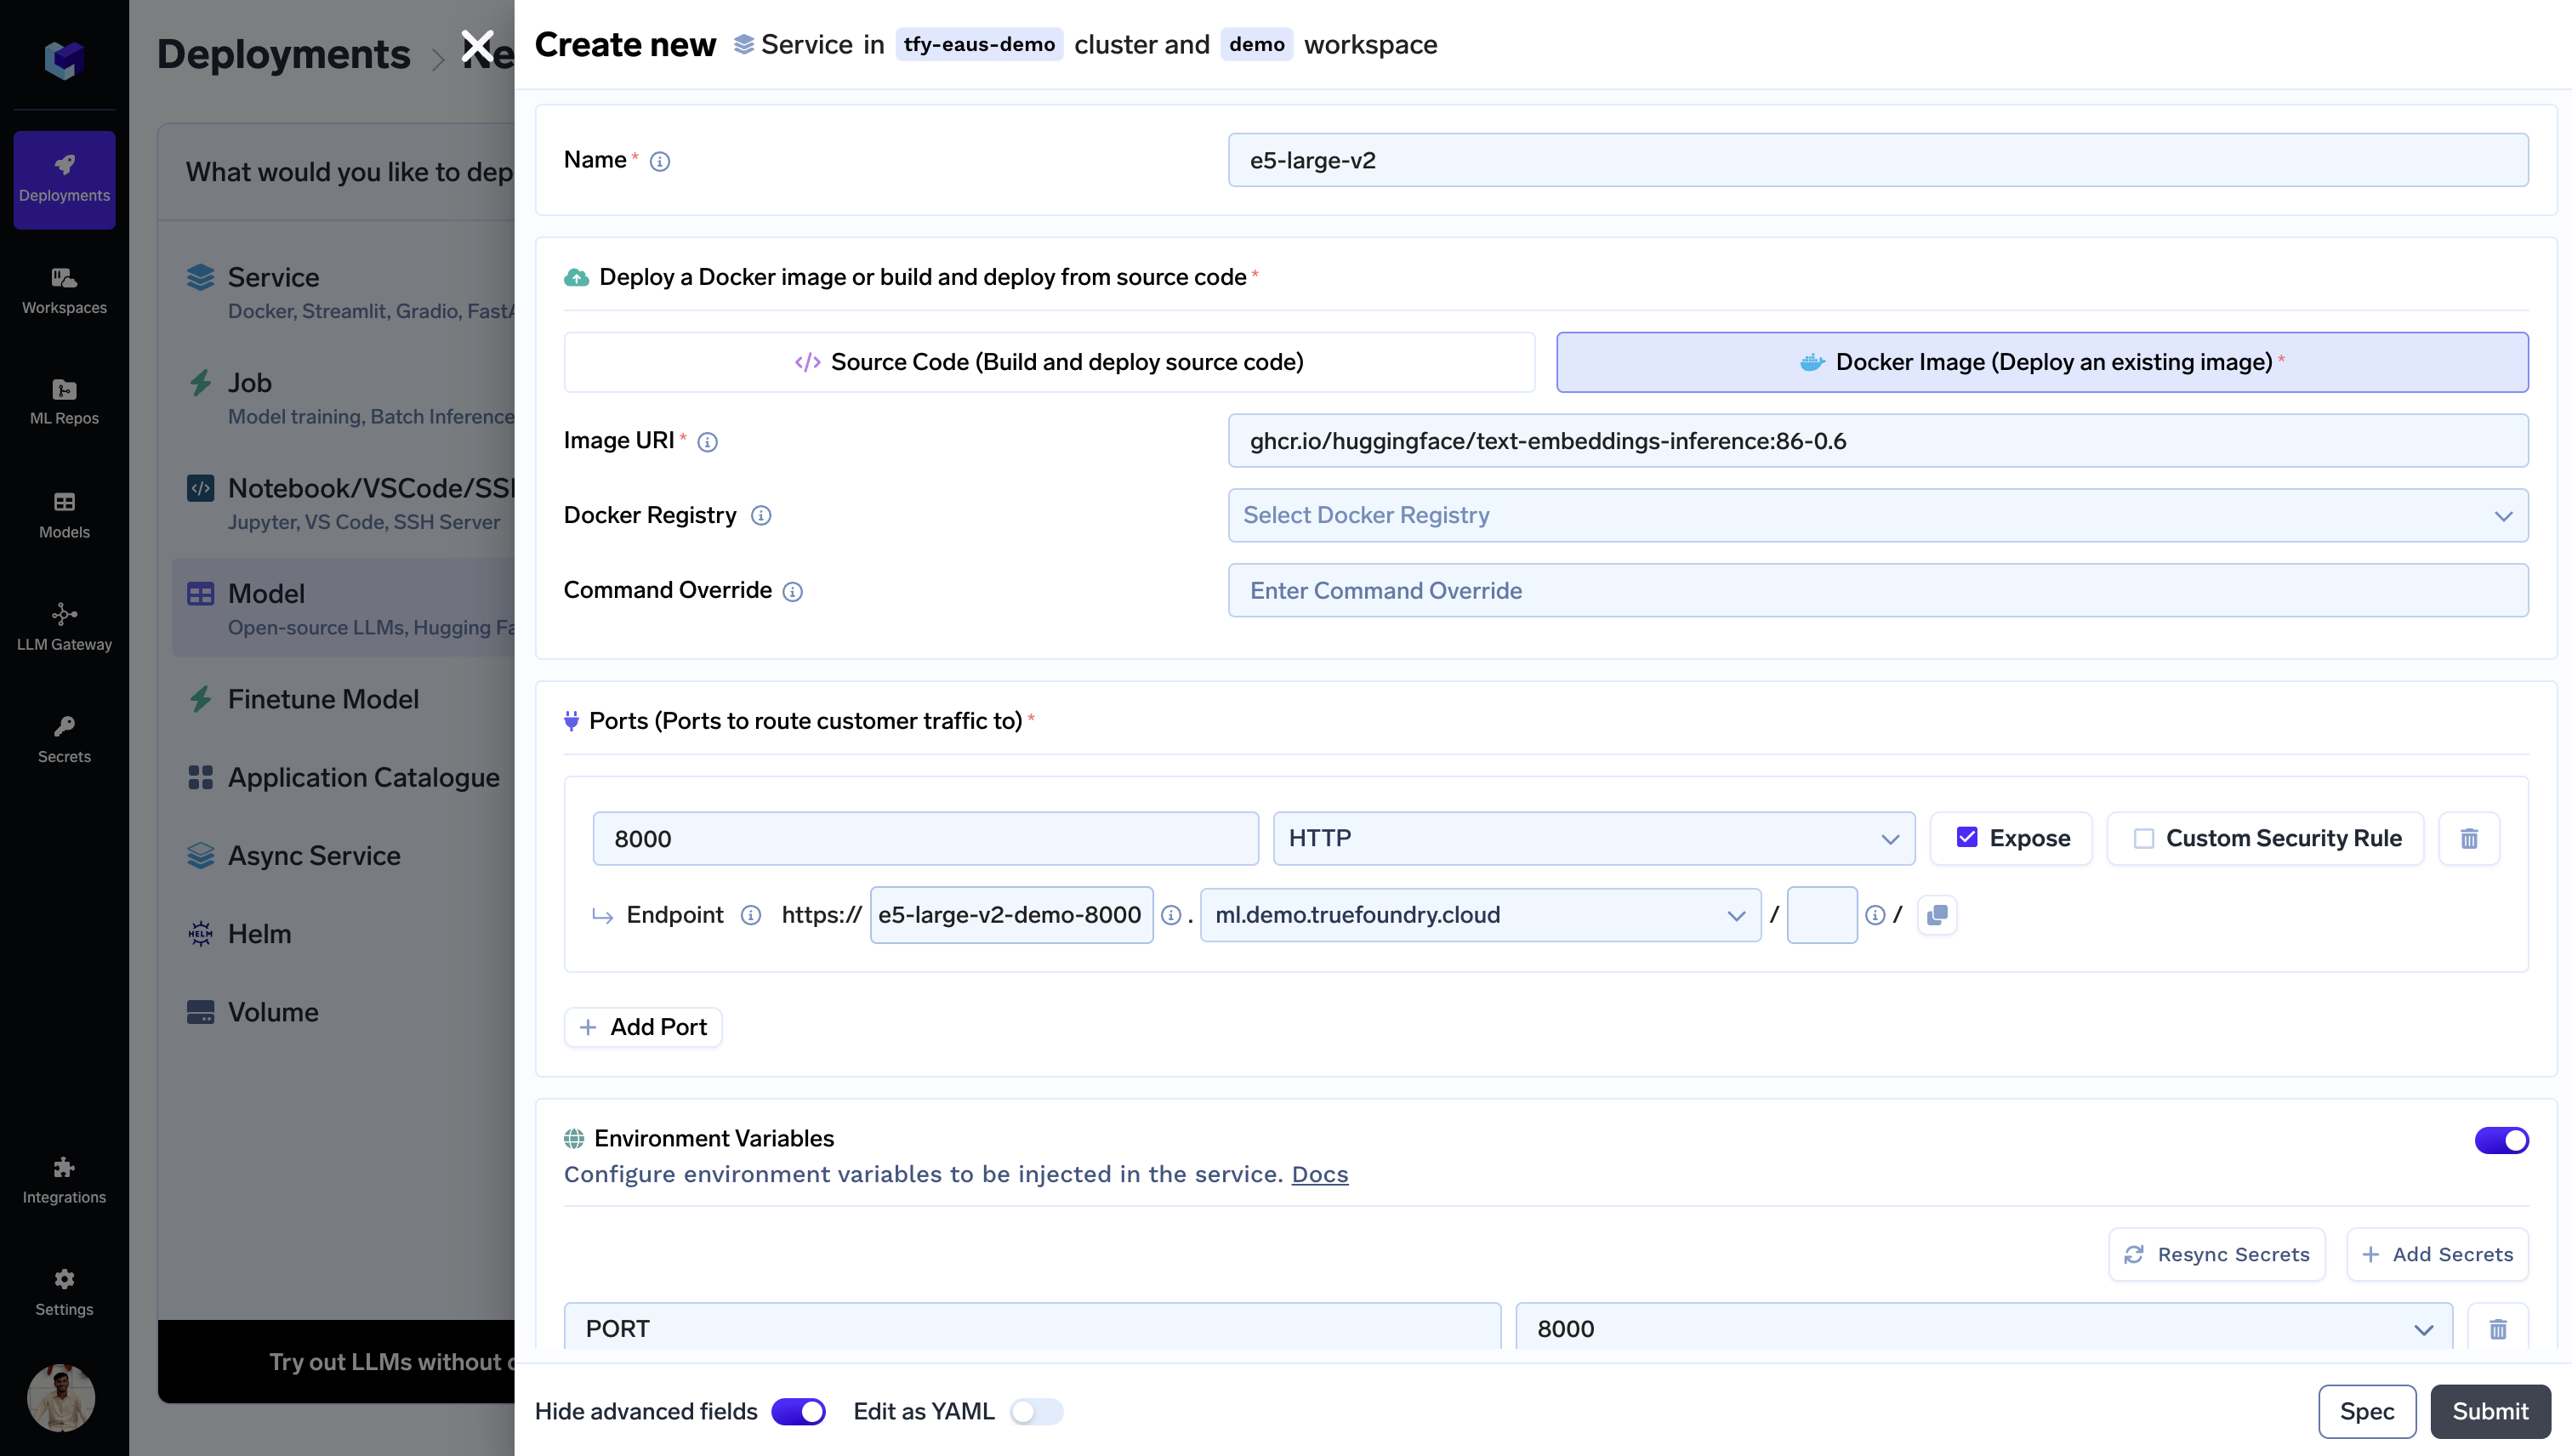


This should start a Deployment, You can find it under the `Service` Tab. Copy the endpoint that will be used in next section.
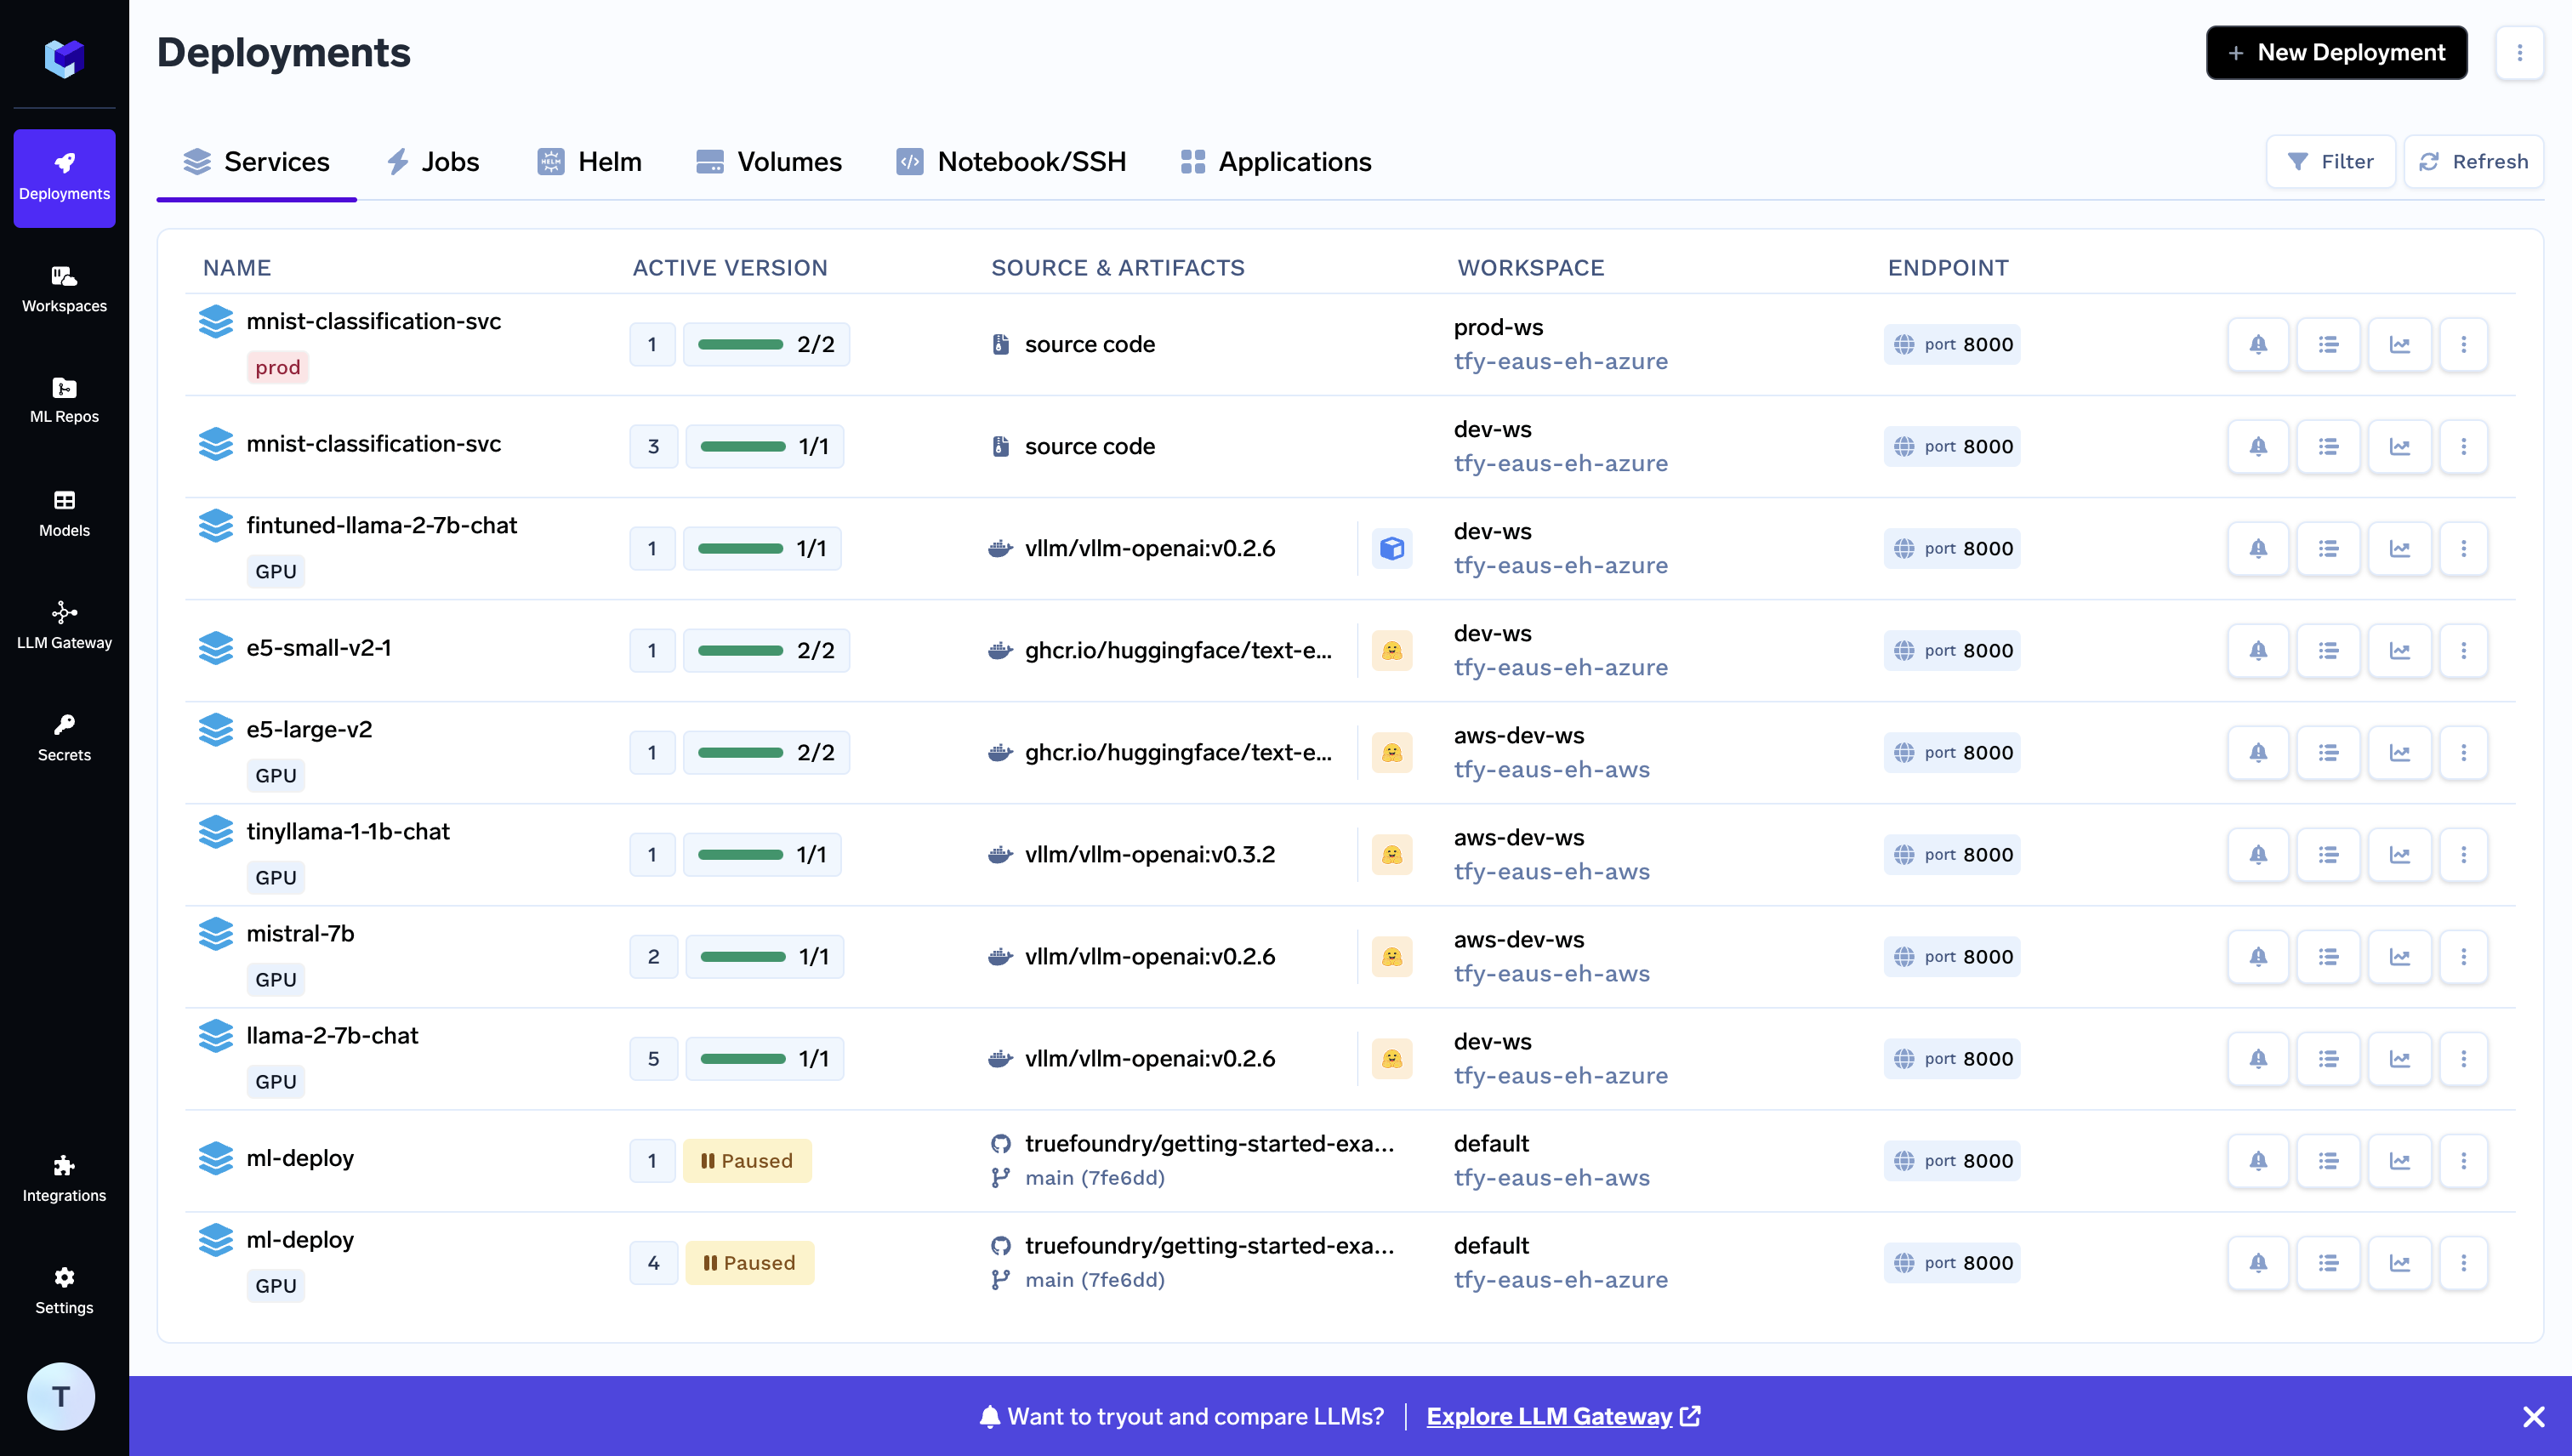

#### Using the deployed Embedding Model

> Replace `EMBEDDING_ENDPOINT` with the model accessible to you

In [ ]:
from tfy_embeddings import TrueFoundryEmbeddings
import numpy as np
import os
# Pass `auth` if you have added username and password on your endpoint

EMBEDDING_ENDPOINT = "https://e5-large-v2-aws-dev-ws-8000.eh-aws.ml.eh-sandbox.truefoundry.cloud"
embedder = TrueFoundryEmbeddings(
    endpoint_url=EMBEDDING_ENDPOINT,
)

np.array(embedder.embed_documents(["This is a test", "This is yet another test"])).shape

## 3. Indexing Vector into VectorDB

Here we will use in memory [Chroma](https://docs.trychroma.com/getting-started) DB, but we can also choose to use a remote Qdrant, Milvus or Weaviate instance. (TrueFoundry allows you to easily deploy Qdrant, Milvus, Weaviate instances on your own infrastructure 😉)

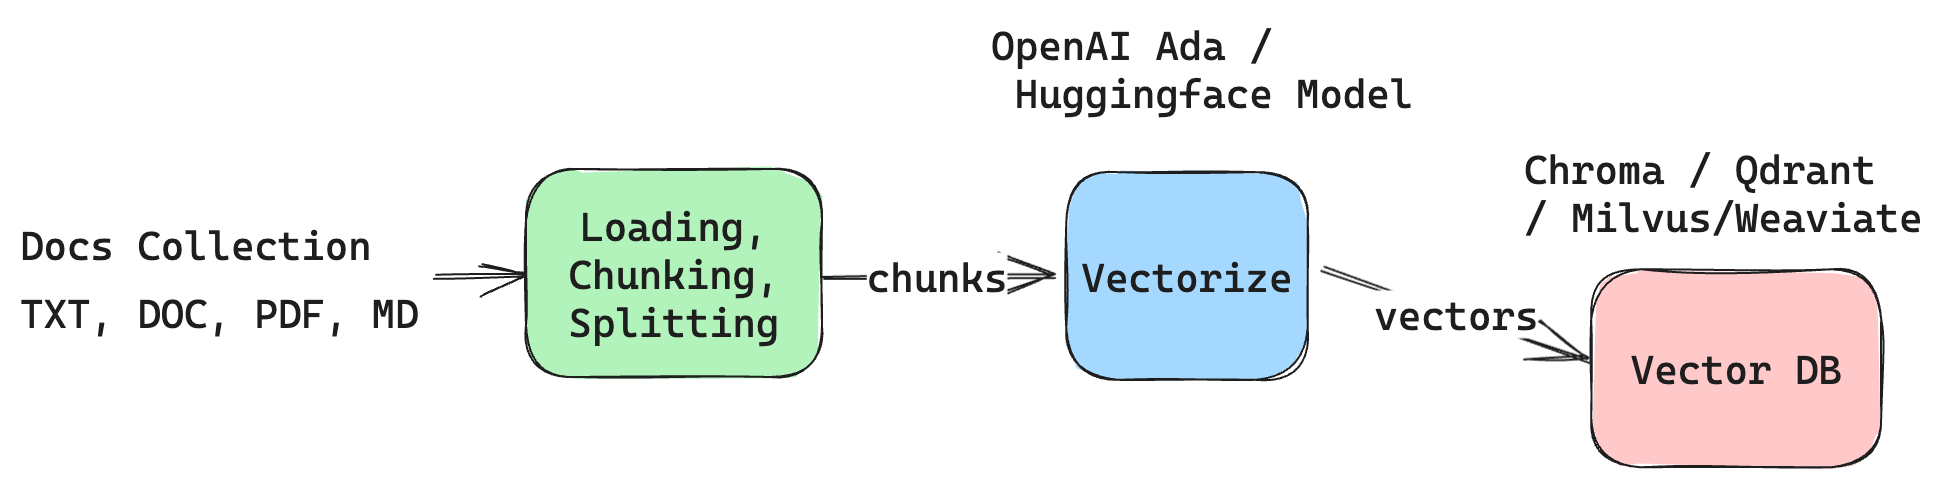

In [ ]:
from langchain.vectorstores import Chroma

PERSIST_DIRECTORY = "./db"

vector_db = Chroma.from_documents(
    documents=chunks,
    ids=ids,
    persist_directory=PERSIST_DIRECTORY,
    embedding=embedder 
)
vector_db._collection.count()

In [ ]:
print("Persisting db ...")
vector_db.persist()

In [ ]:
print("Reloading DB from disk")
vector_db = Chroma(
    persist_directory=PERSIST_DIRECTORY,
    embedding_function=embedder,
)

vector_db._collection.count()

## 4. LLM and Prompt Template

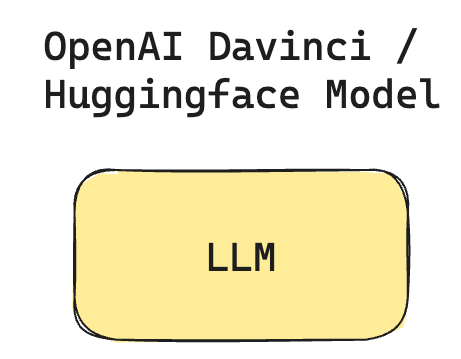

### Using LLM from Model Catalogue (You can directly use from LLM Gateway Also)
**Note:** In case you have resources and want to use an LLM locally, see Appendix section

#### Deploying the LLM

Let's Deploy a LLM model from model catalogue. Navigate to Deployment > New Deployments, select `Model` in the left hand side. Now, select `Workspace` and `Language Models` to deploy.
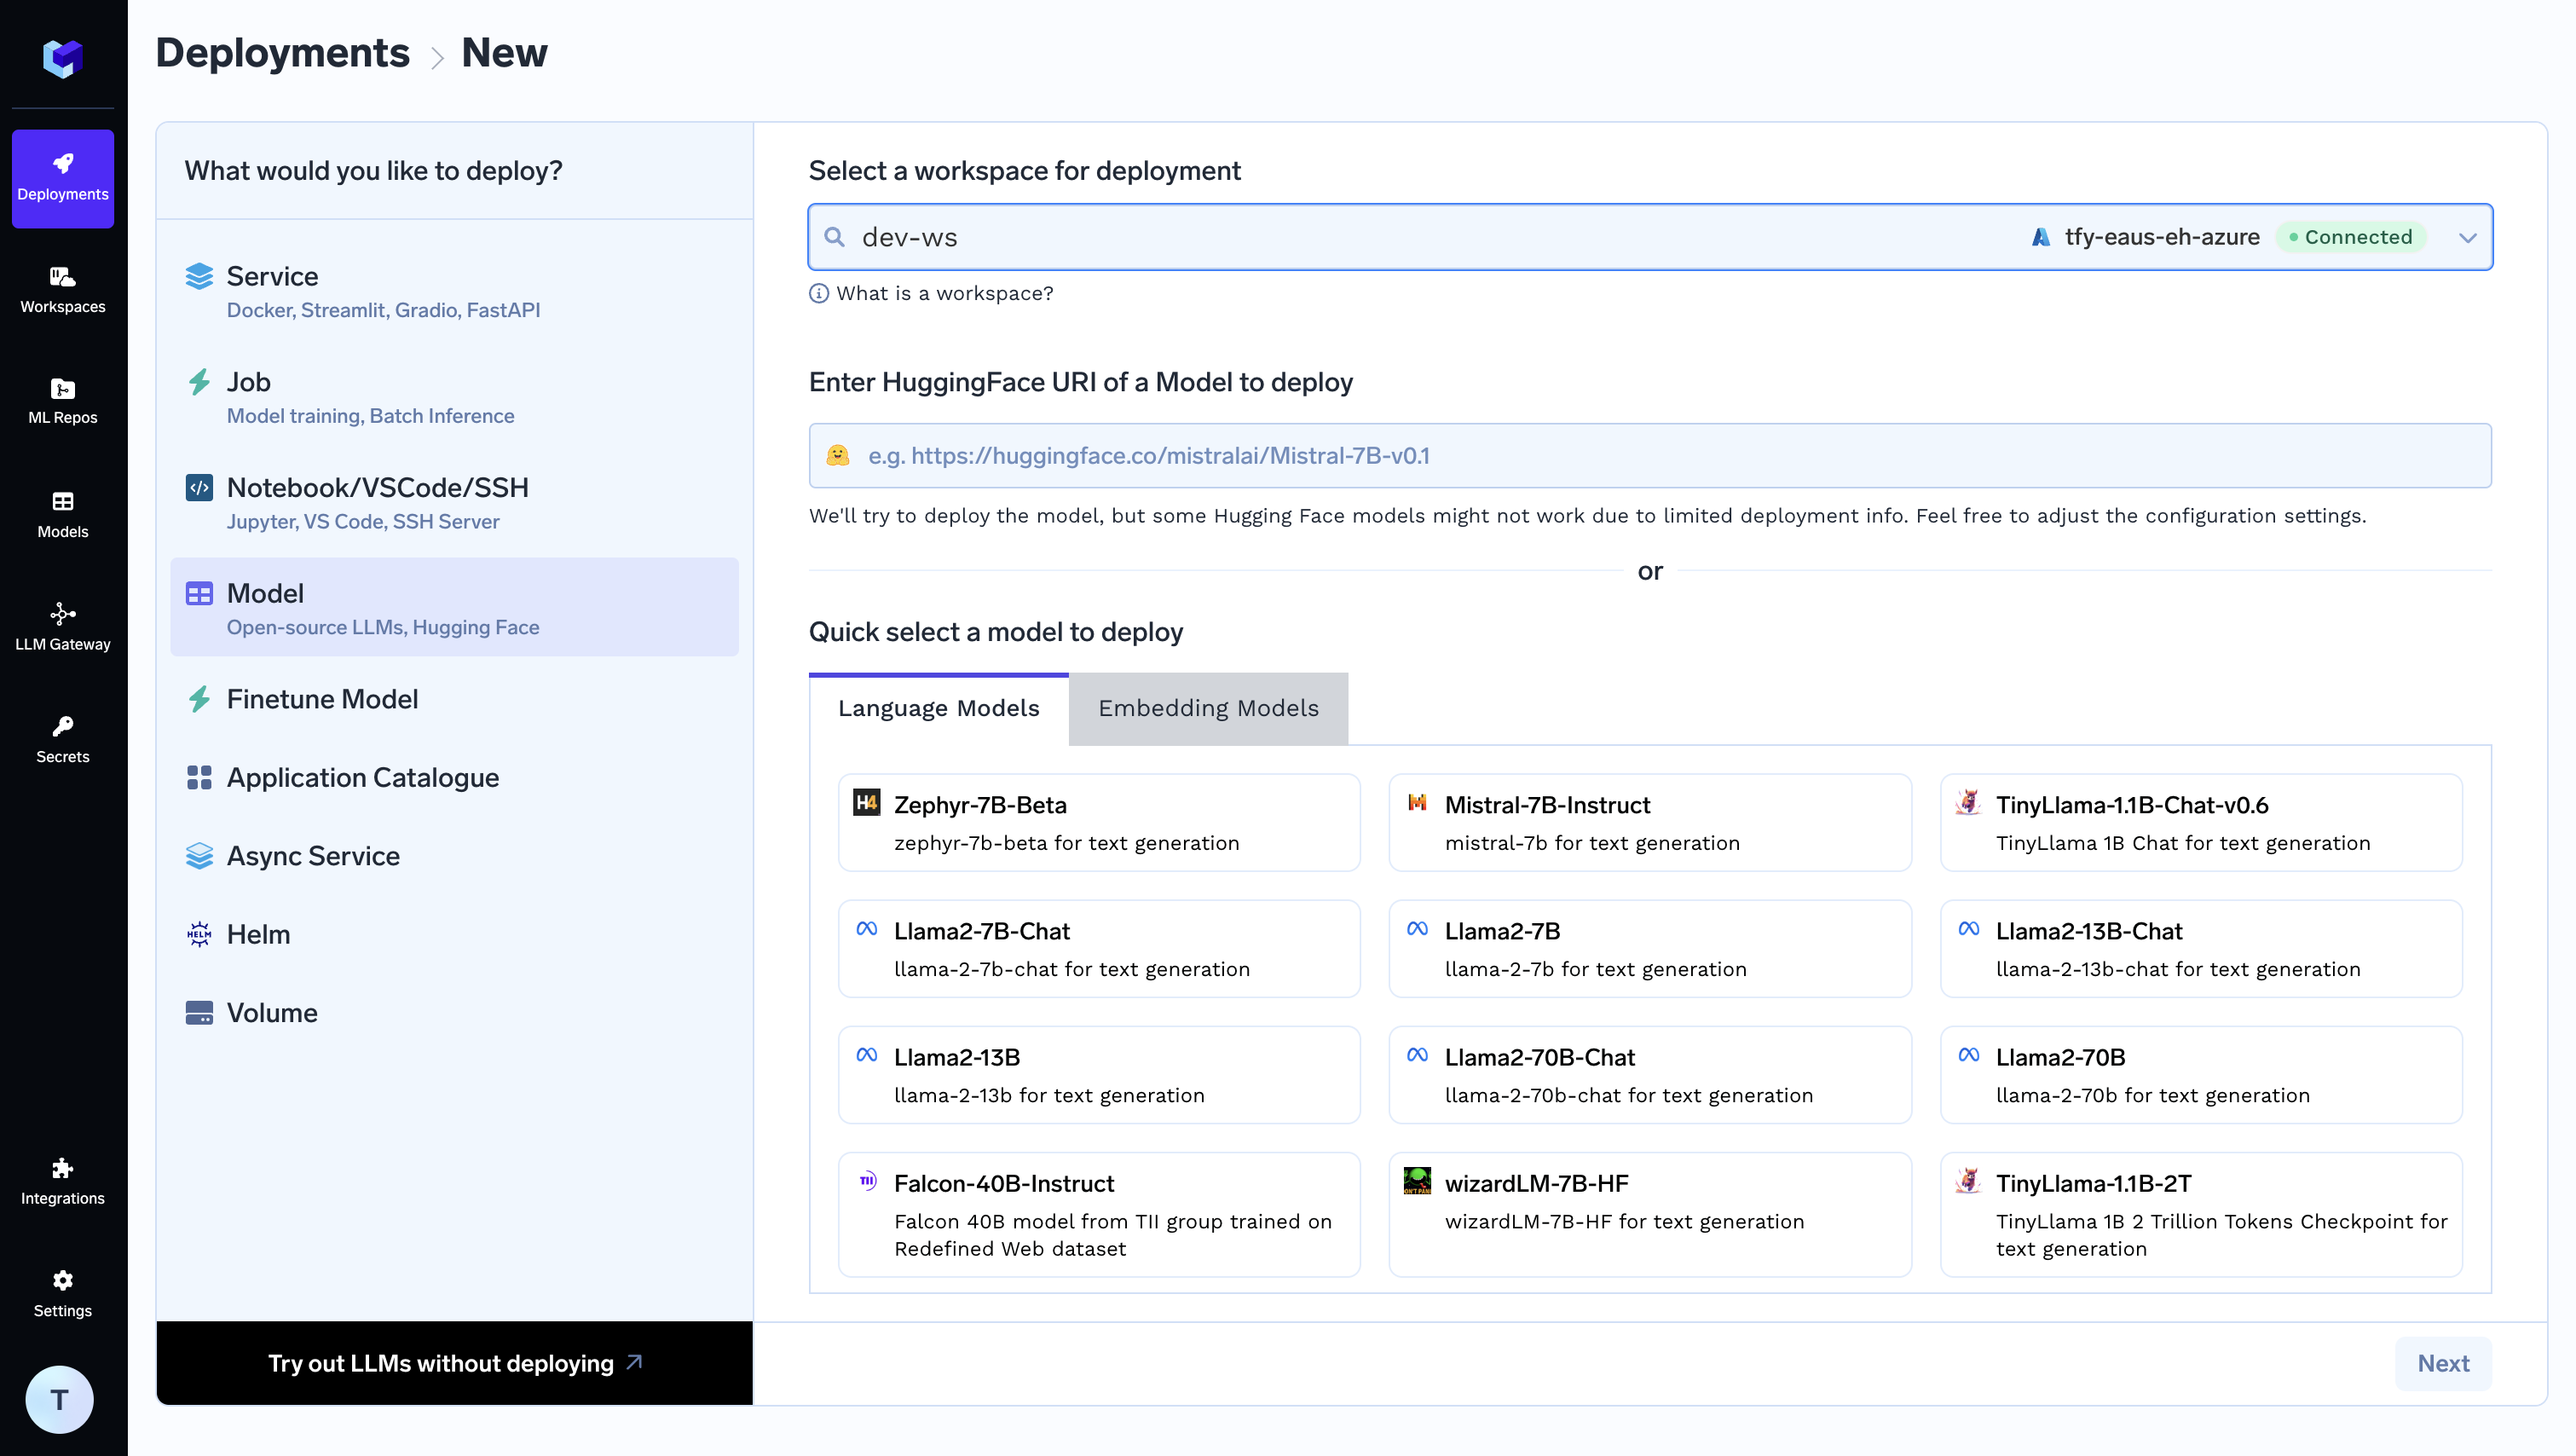


Select a infra configuration, Continue and follow the form, then Submit.
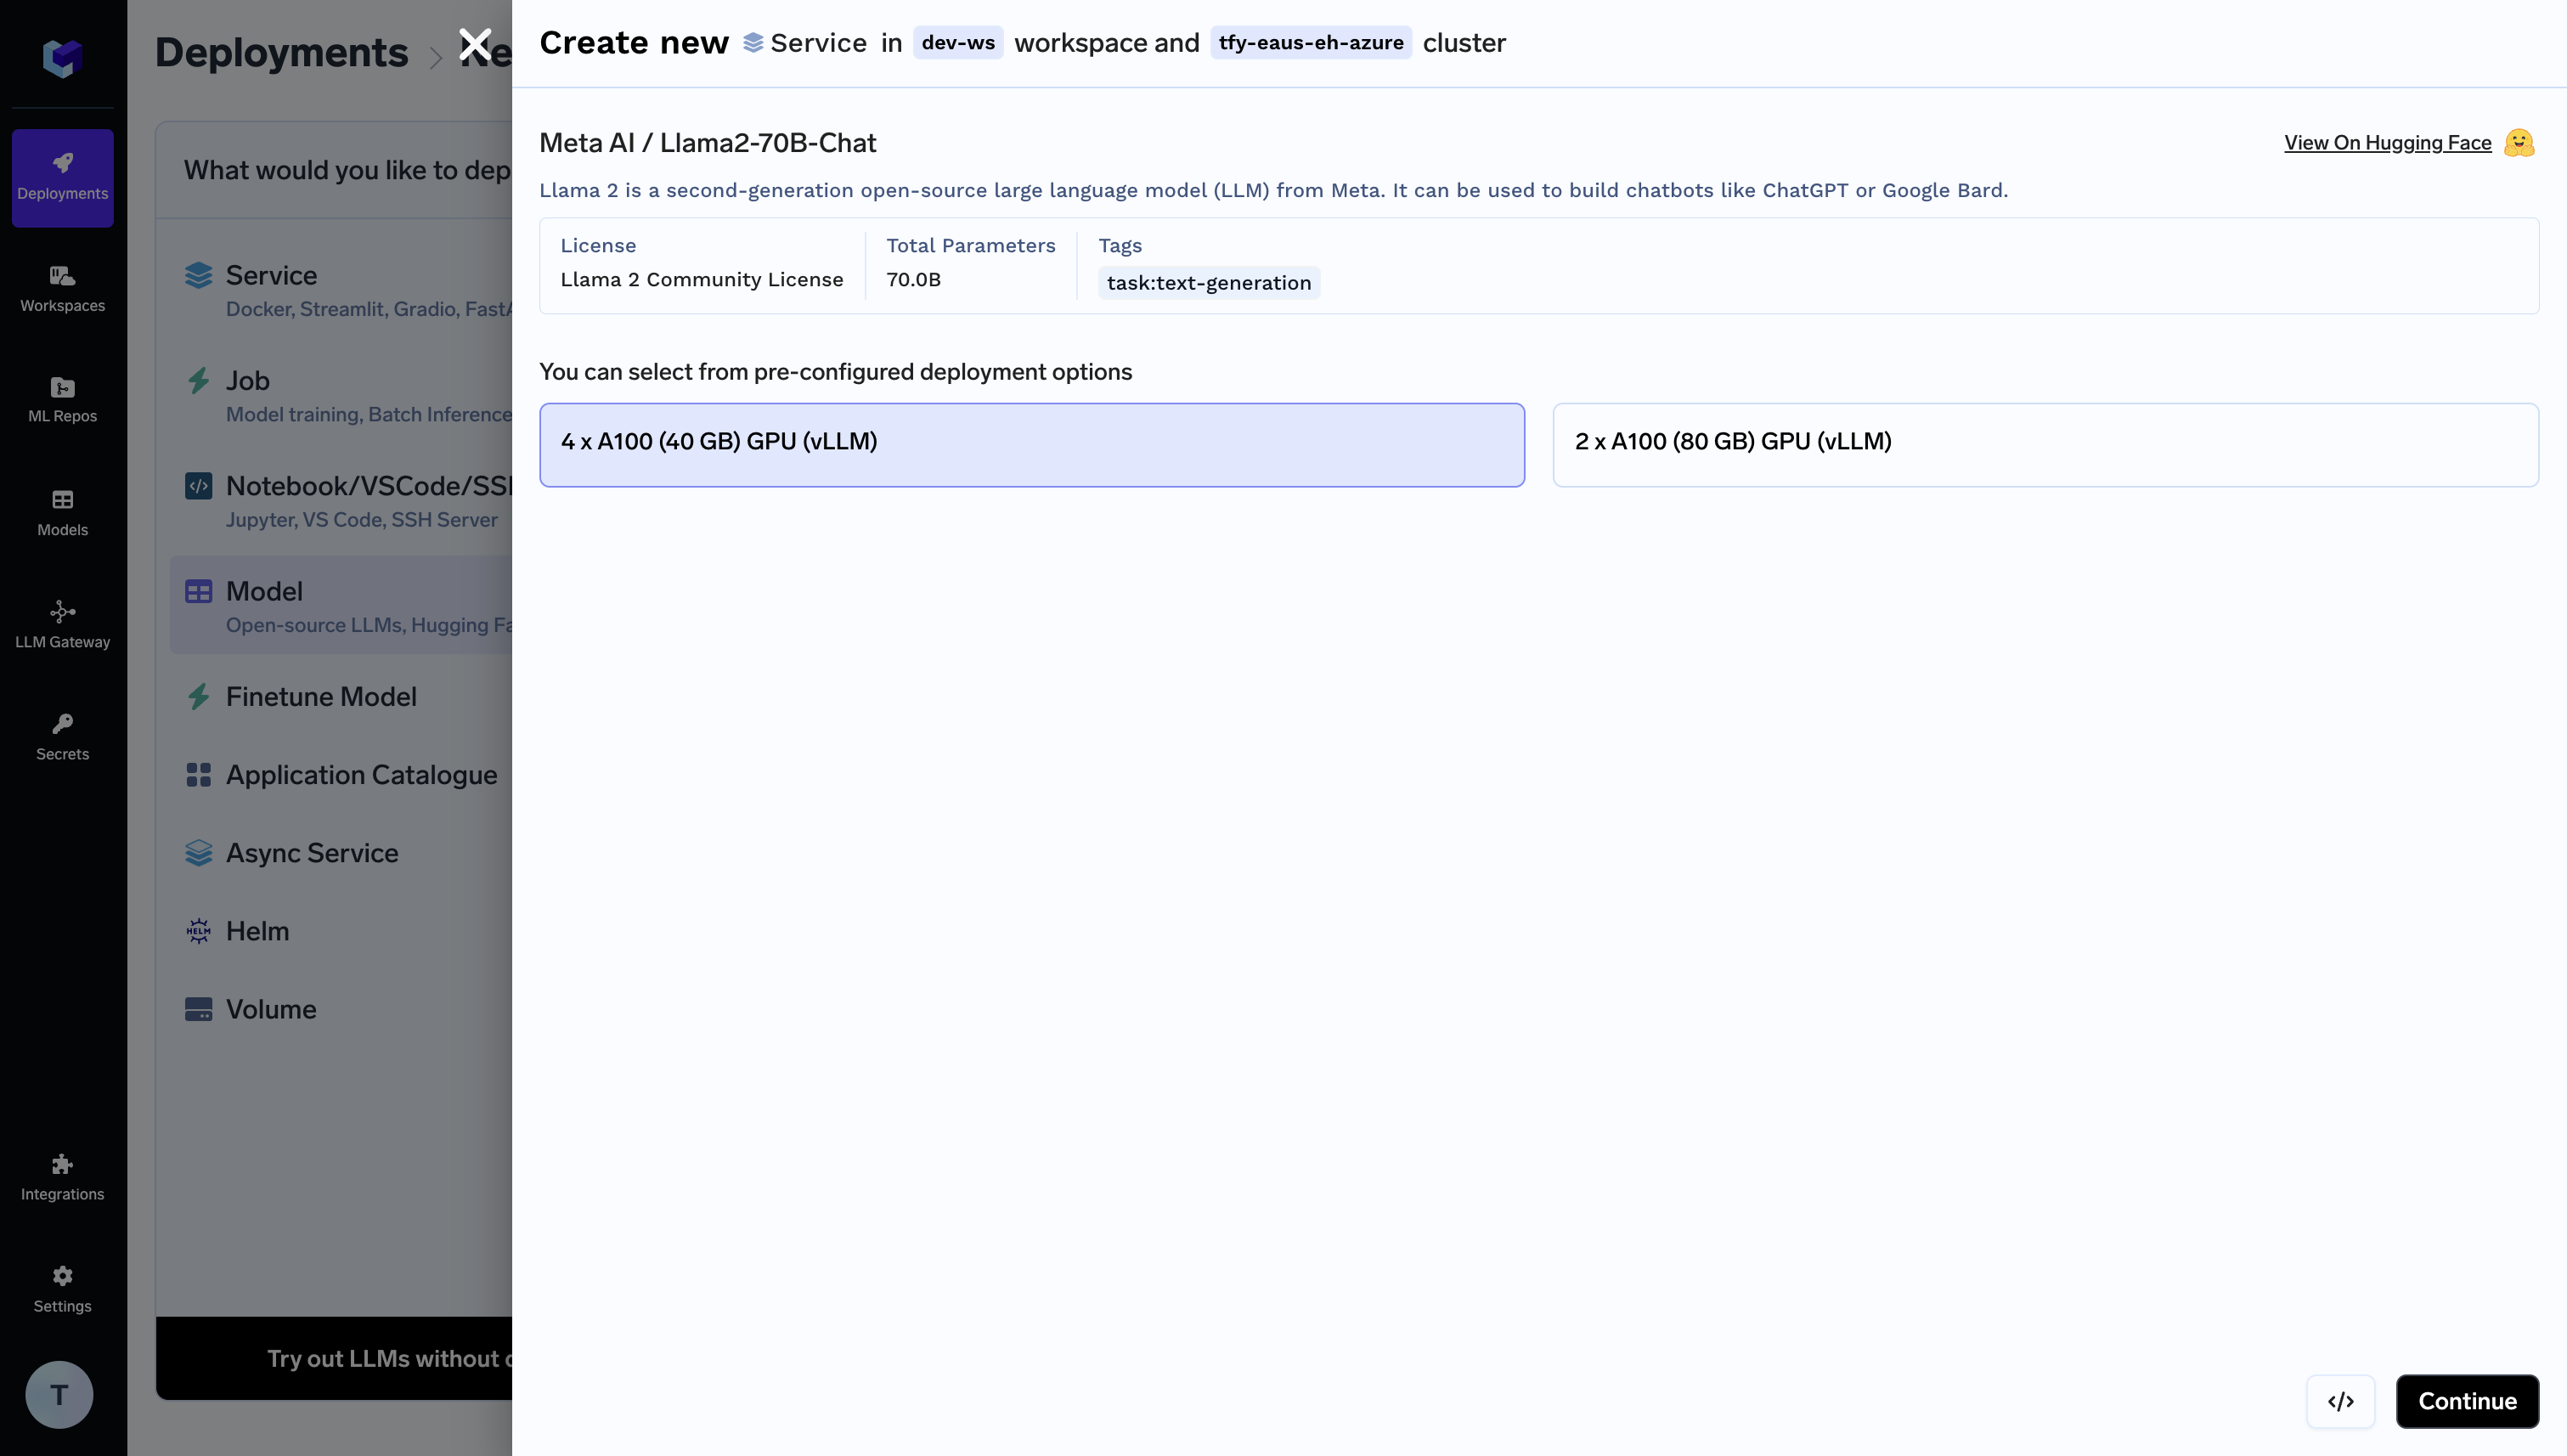
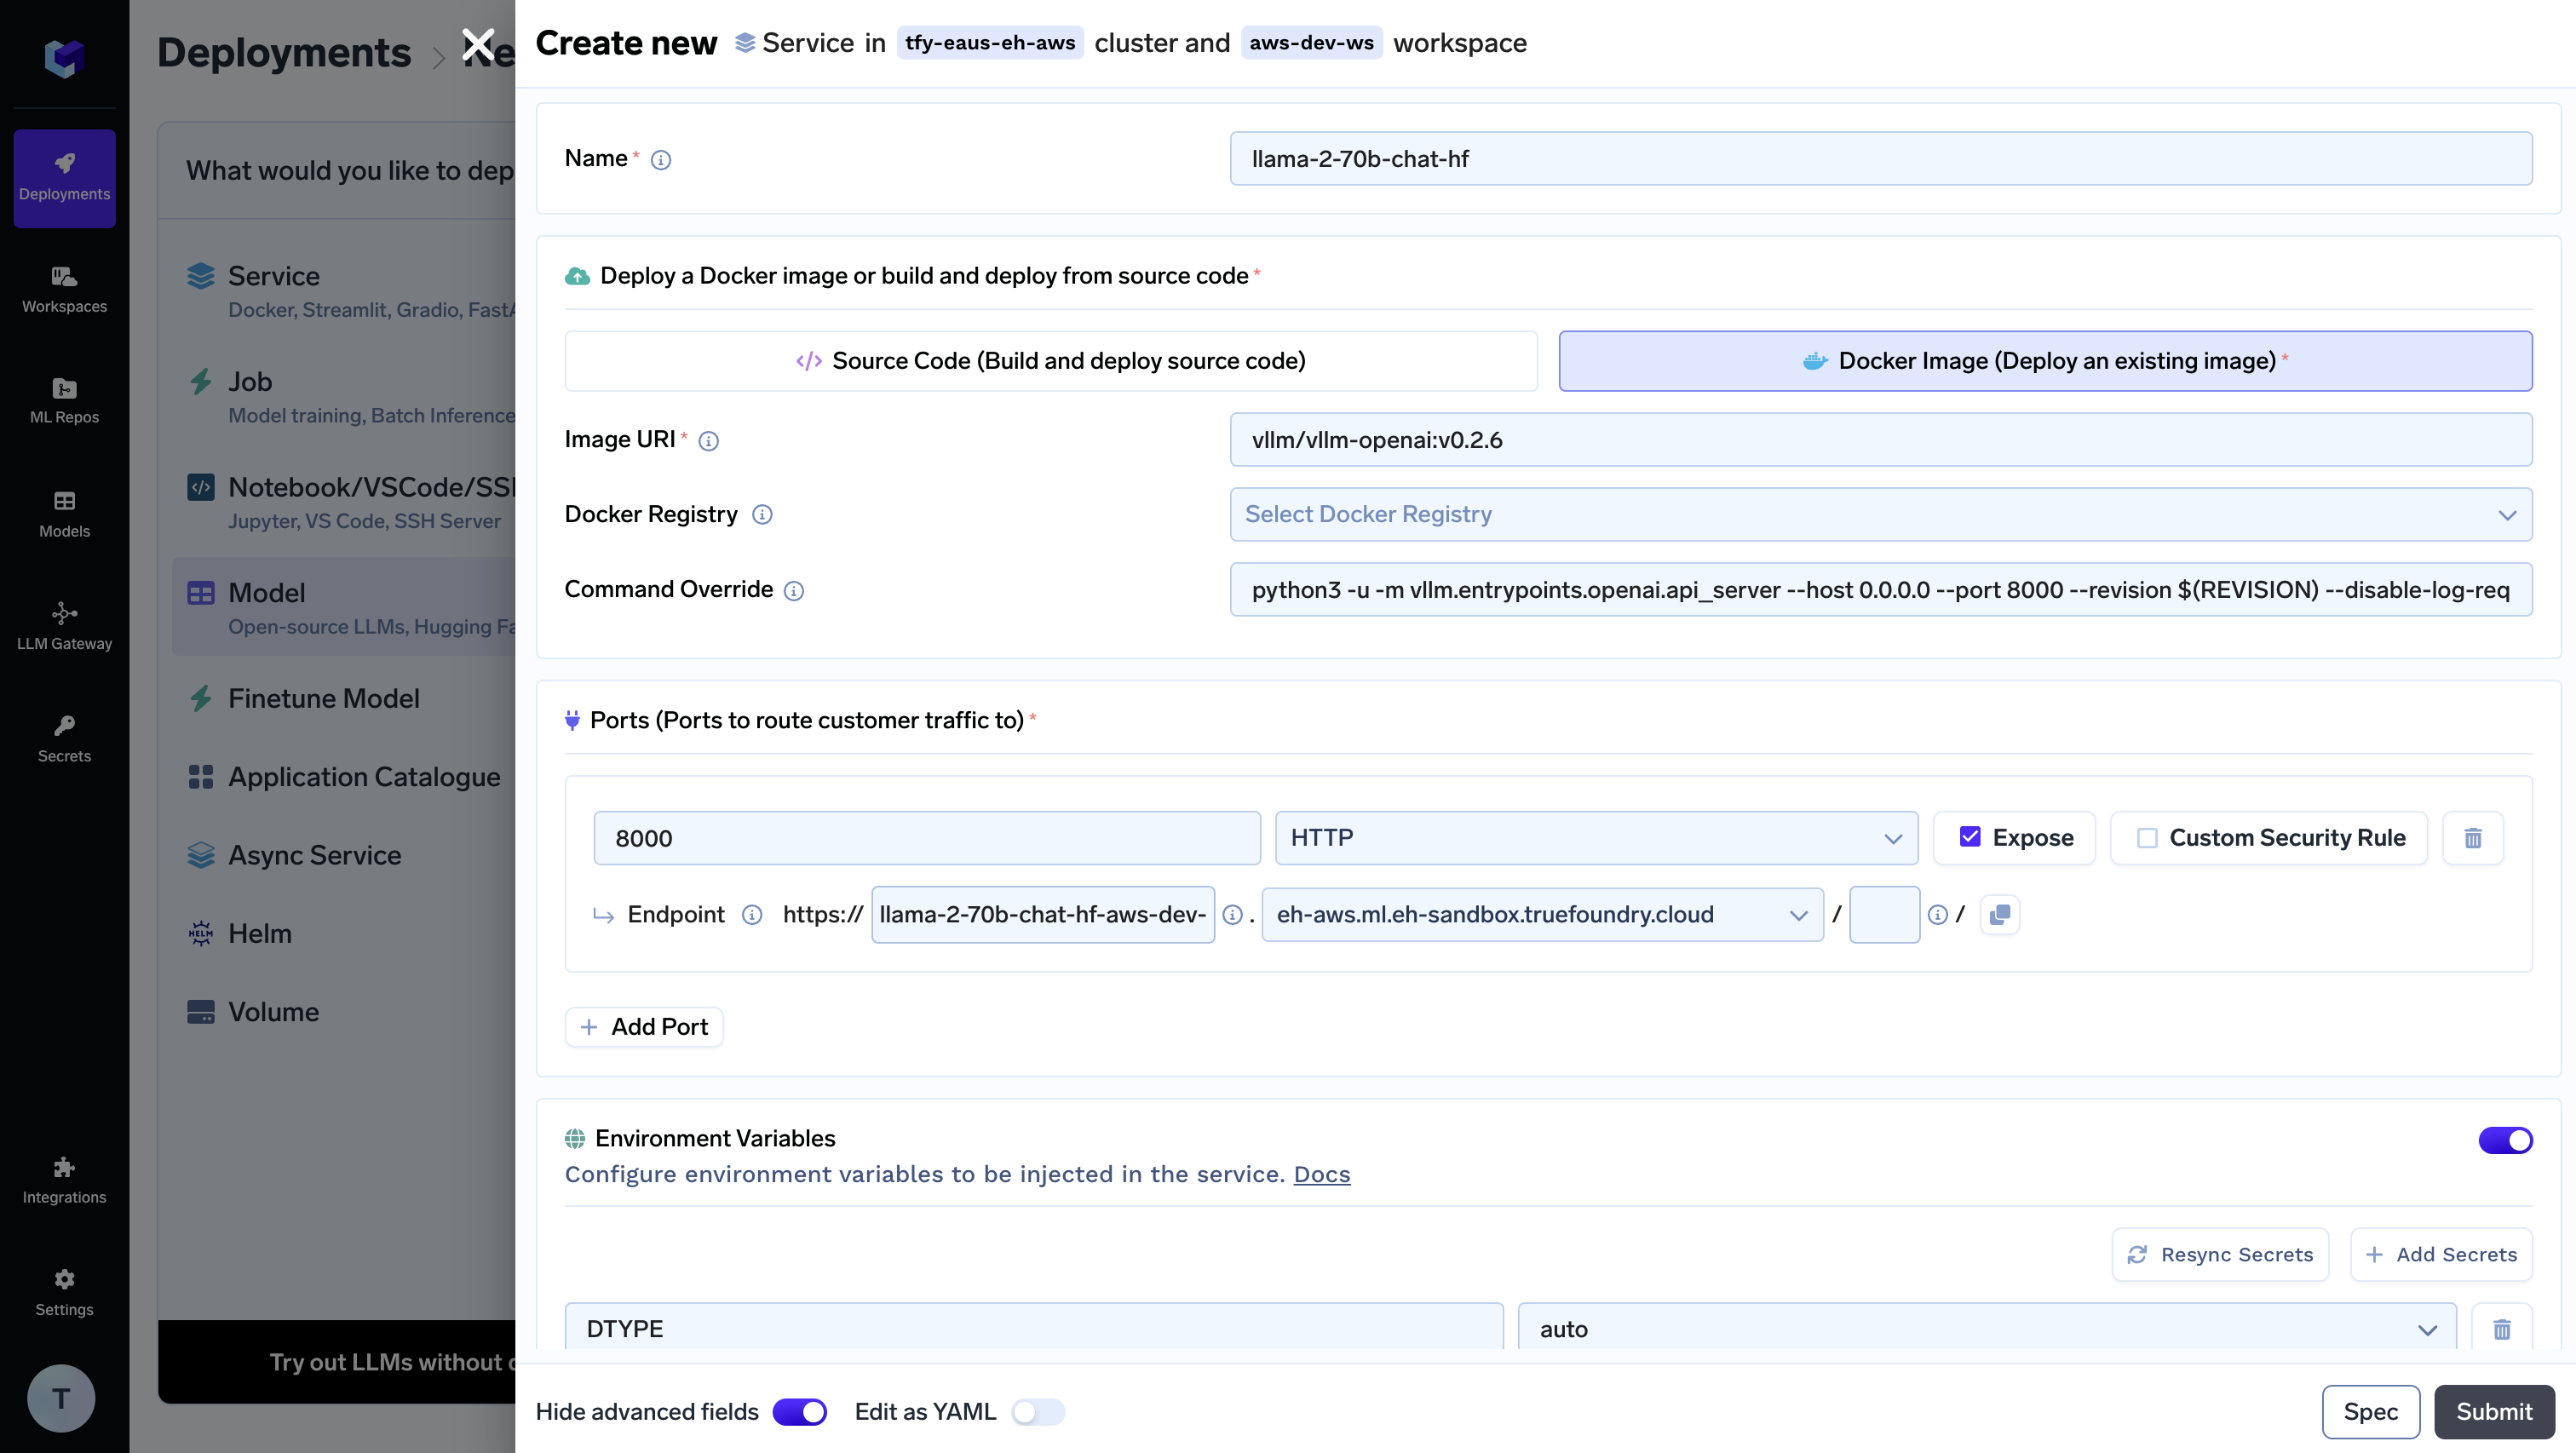
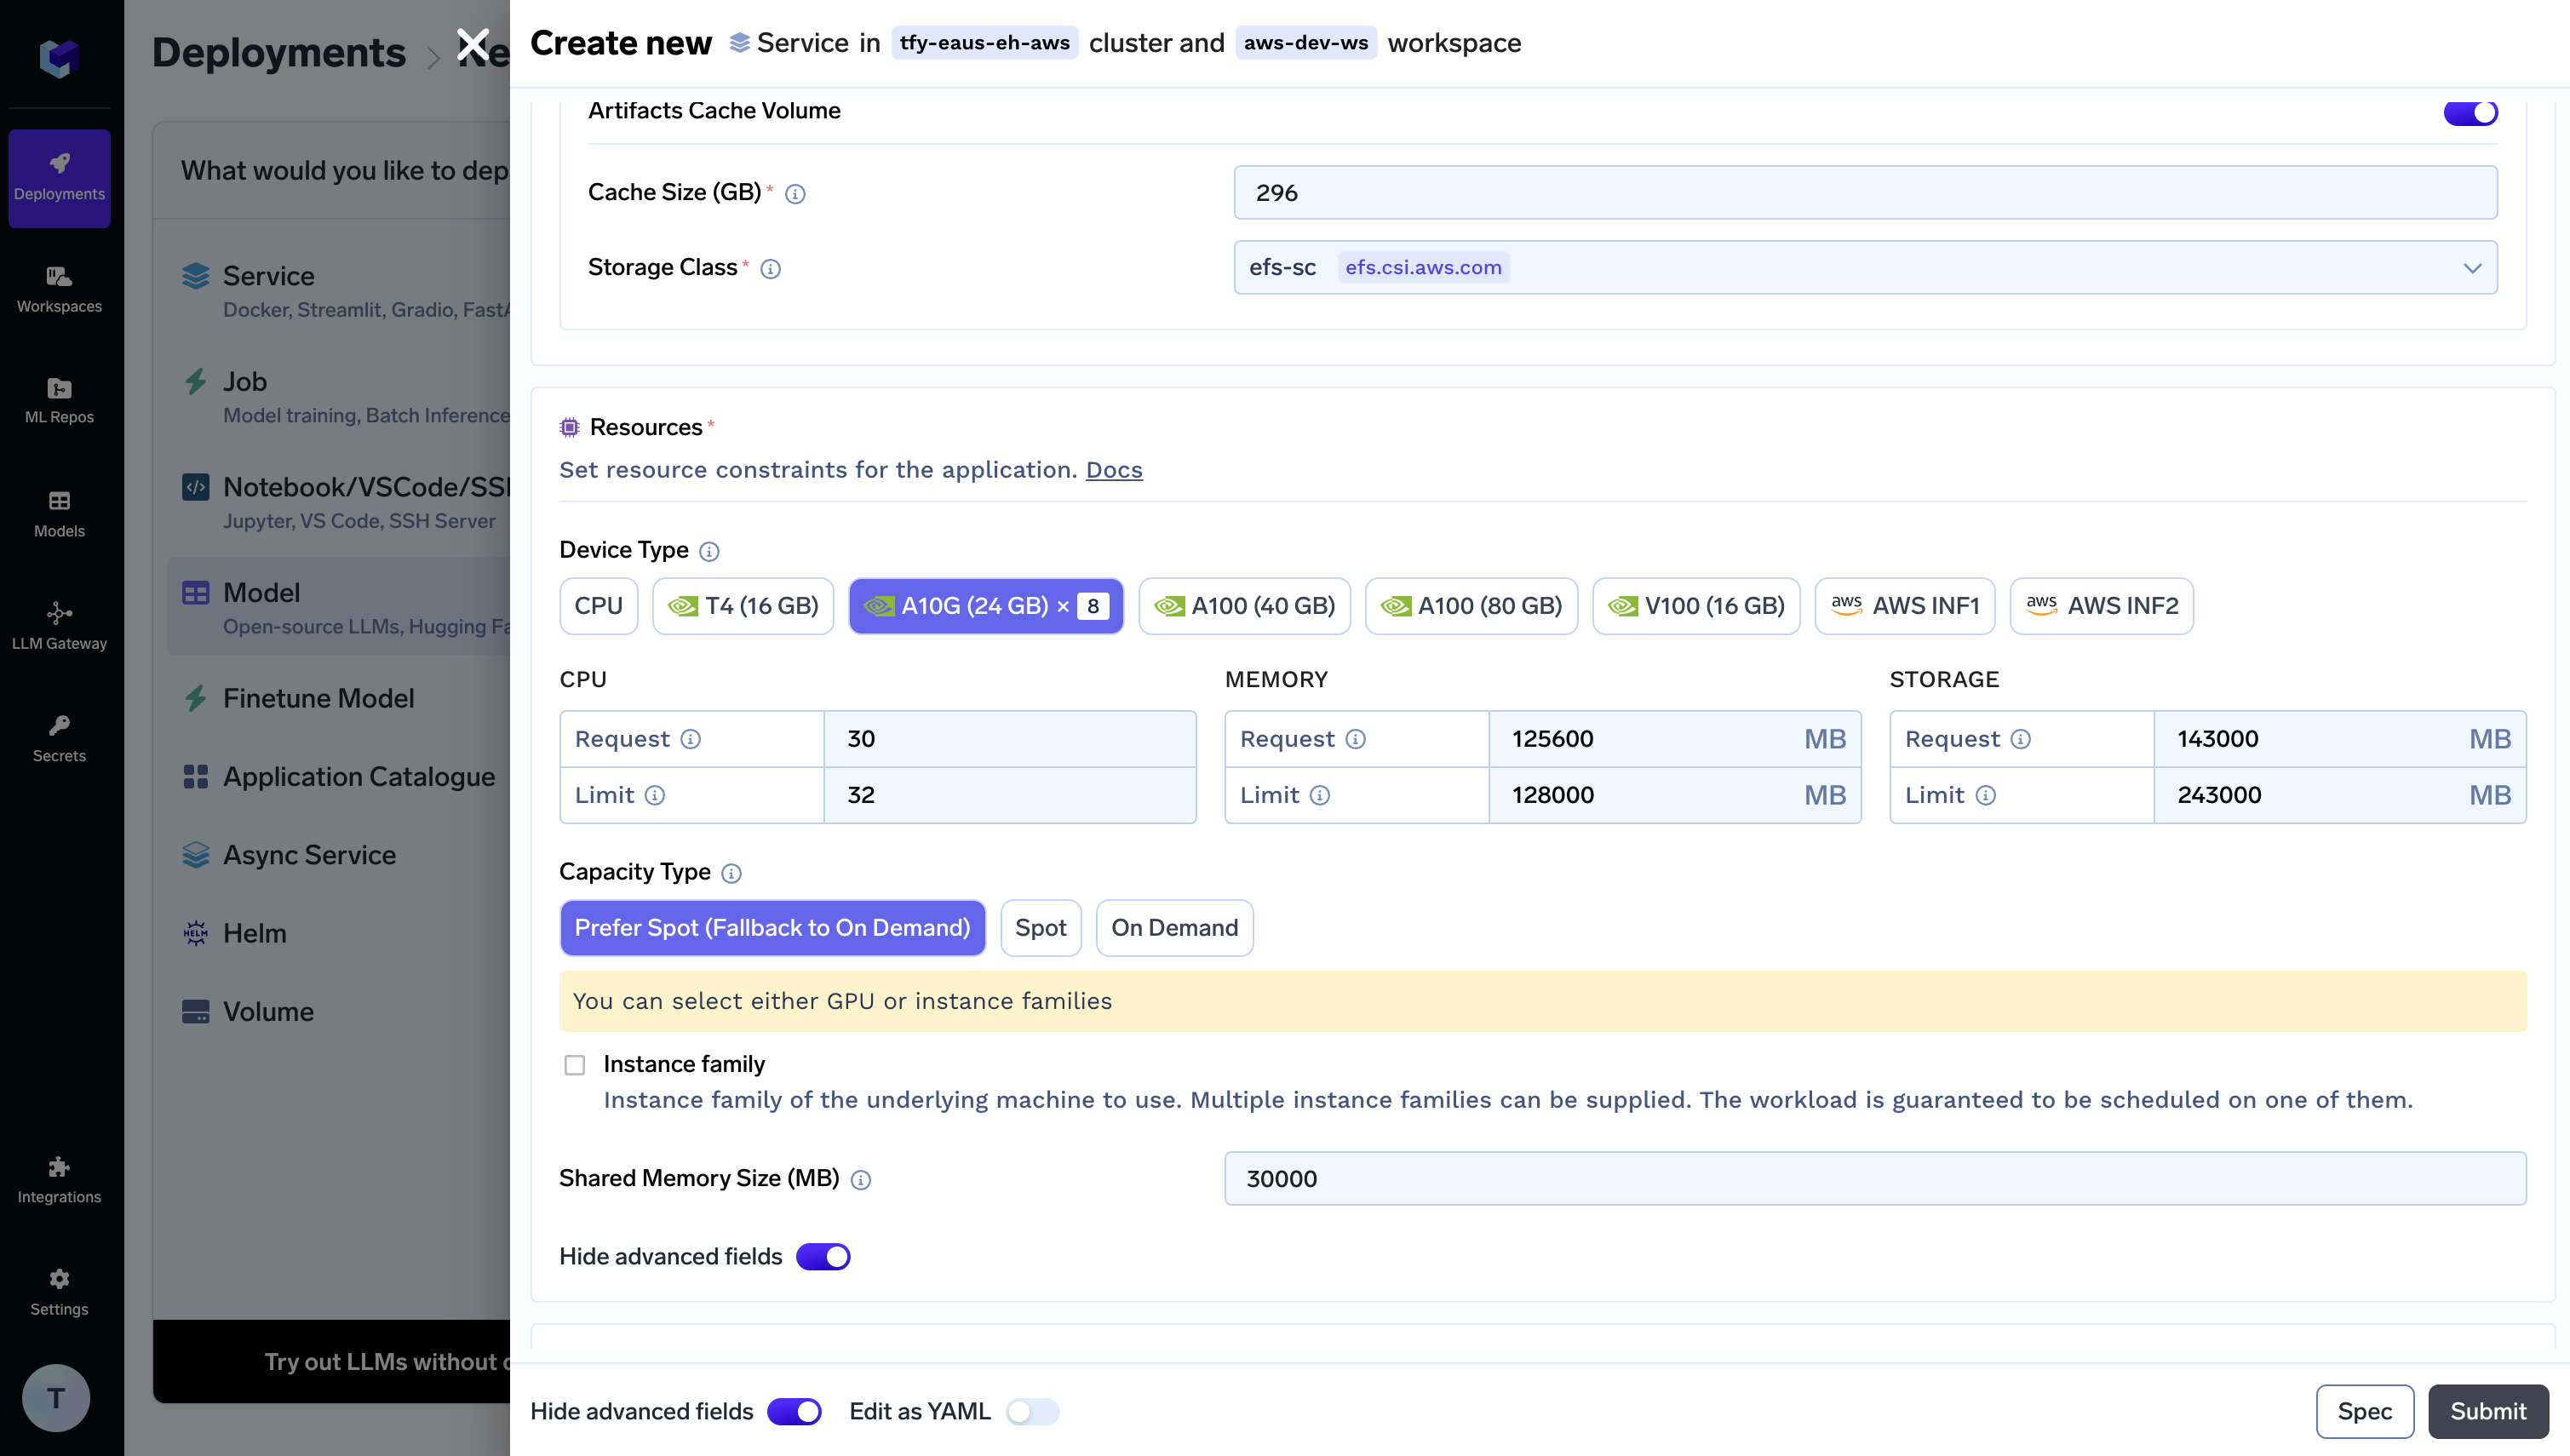

This should start a Deployment, You can find it under the `Service` Tab

Click on the service and then click on `Add to LLM Gateway`
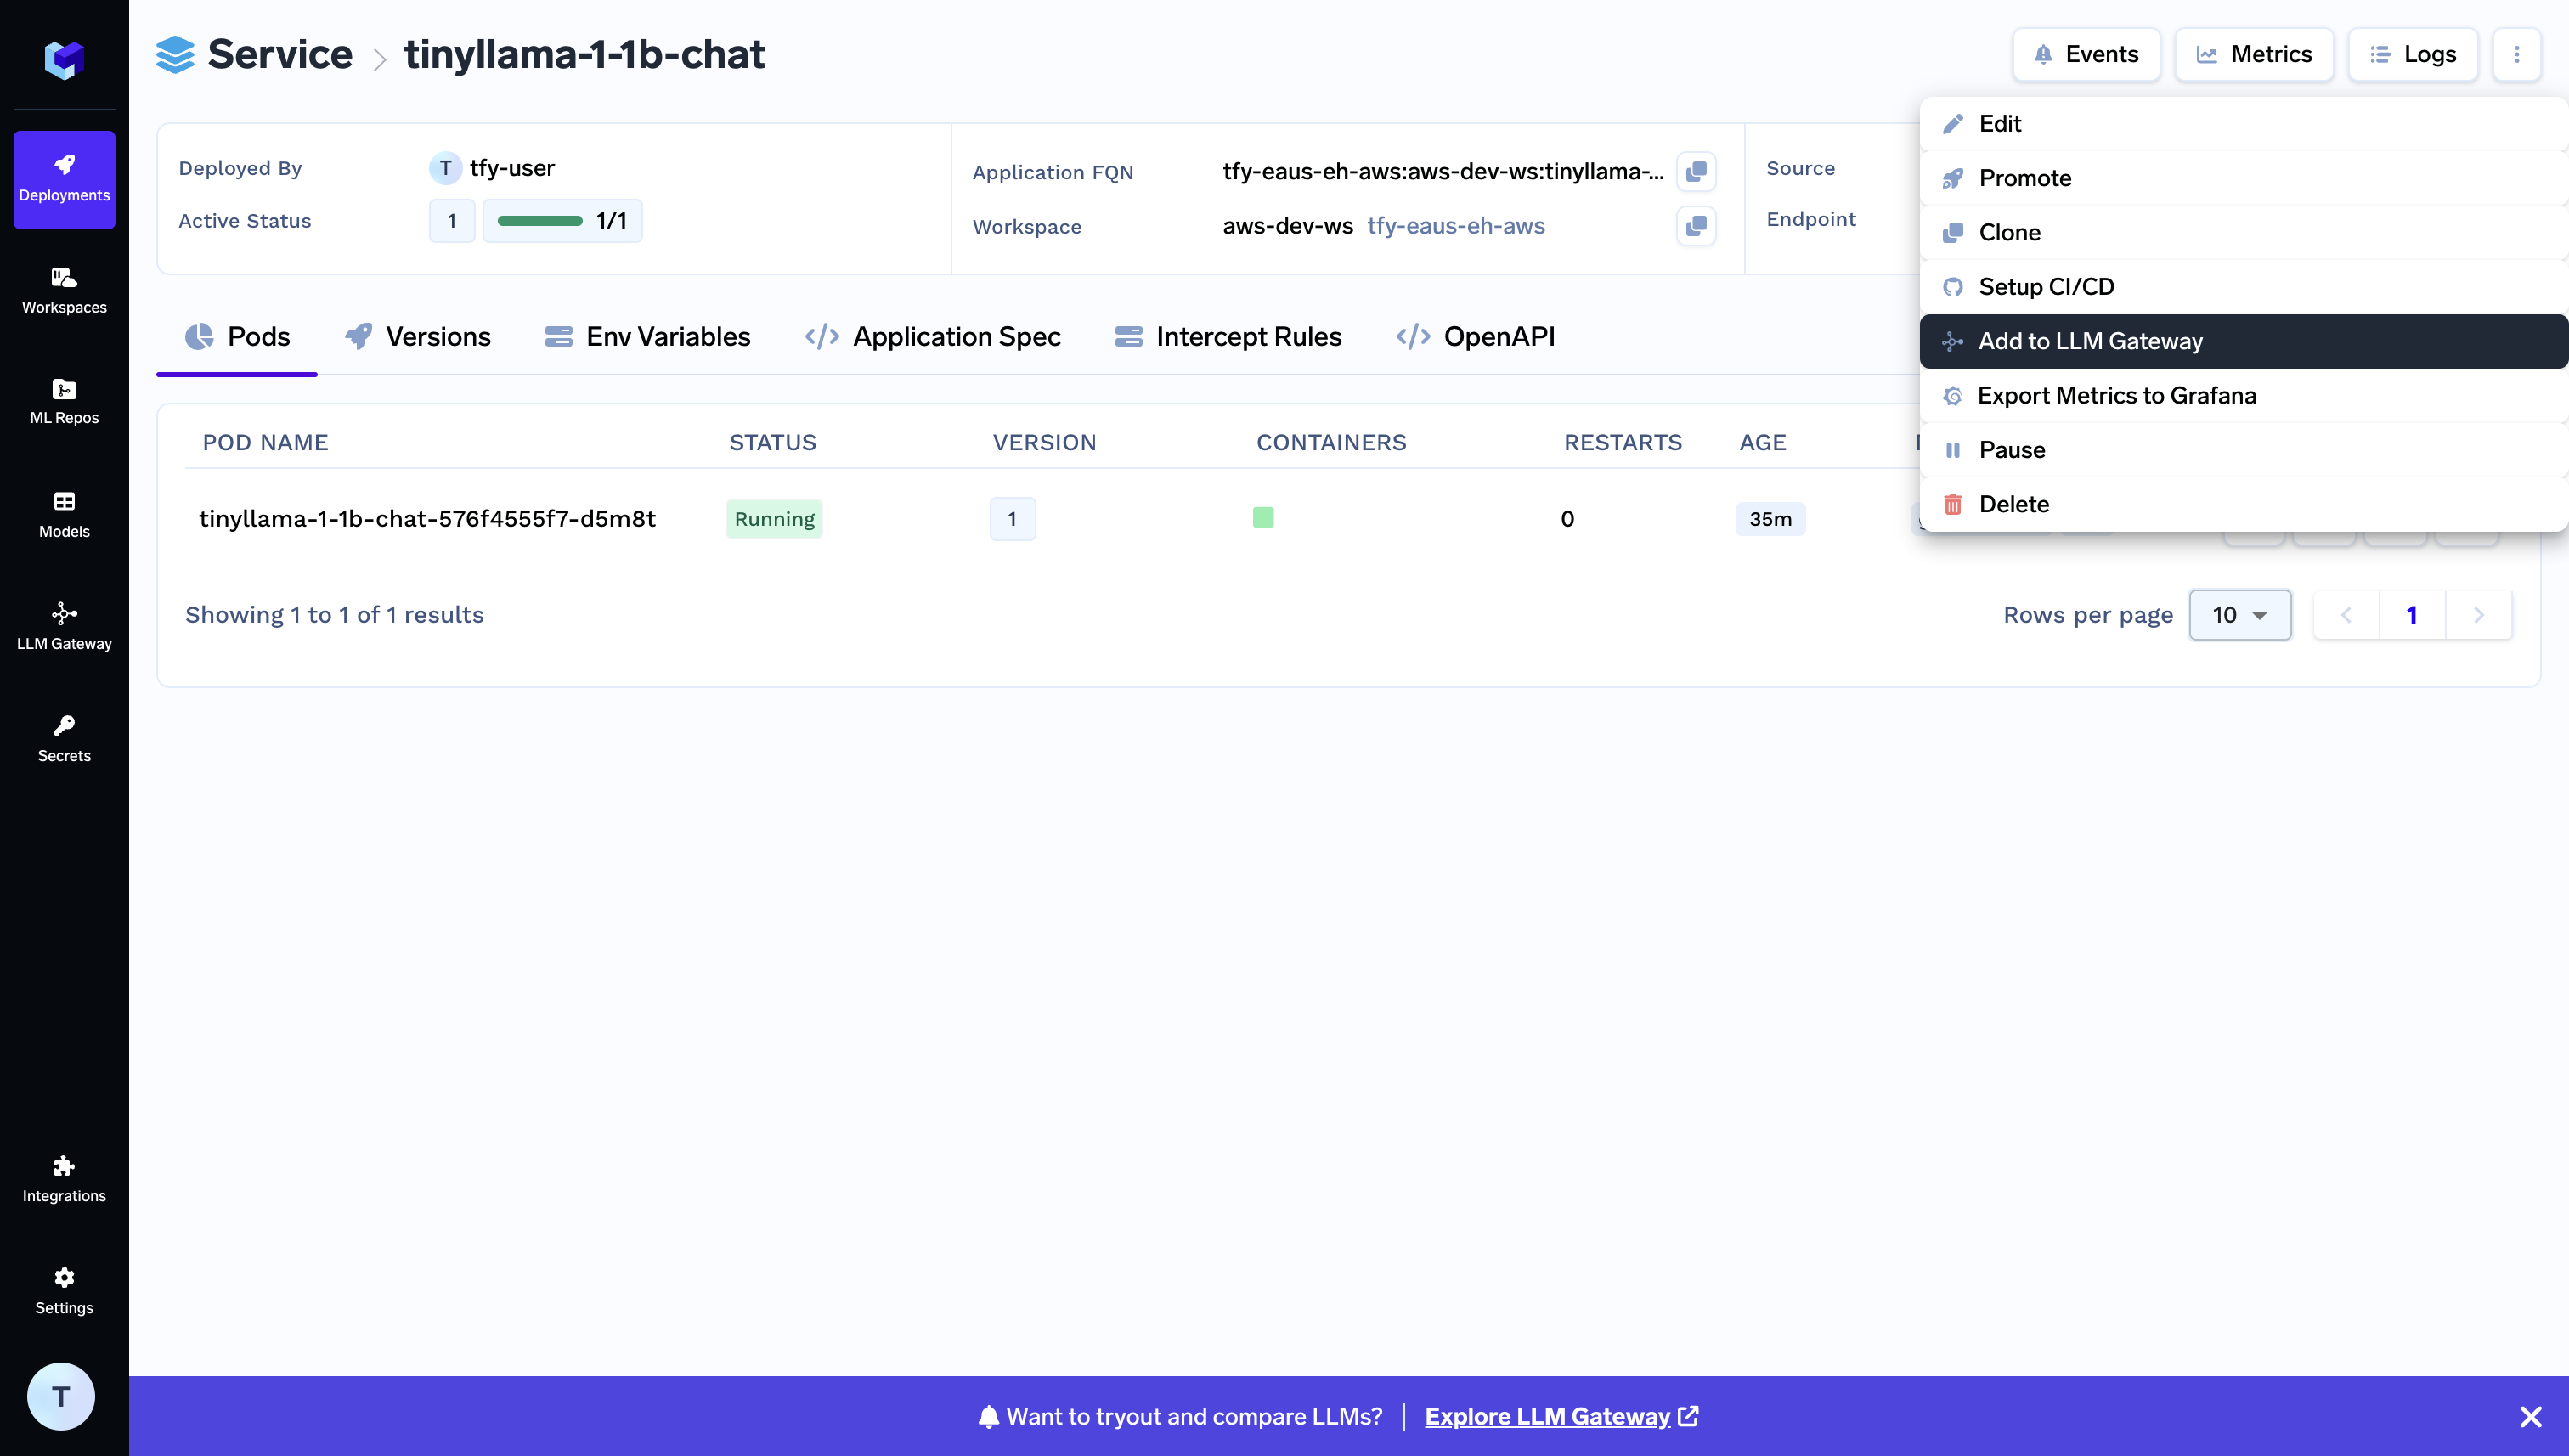


Generate API Key to authenticate. Nagivate to Settings > API Keys, click on `Create New API Key`.
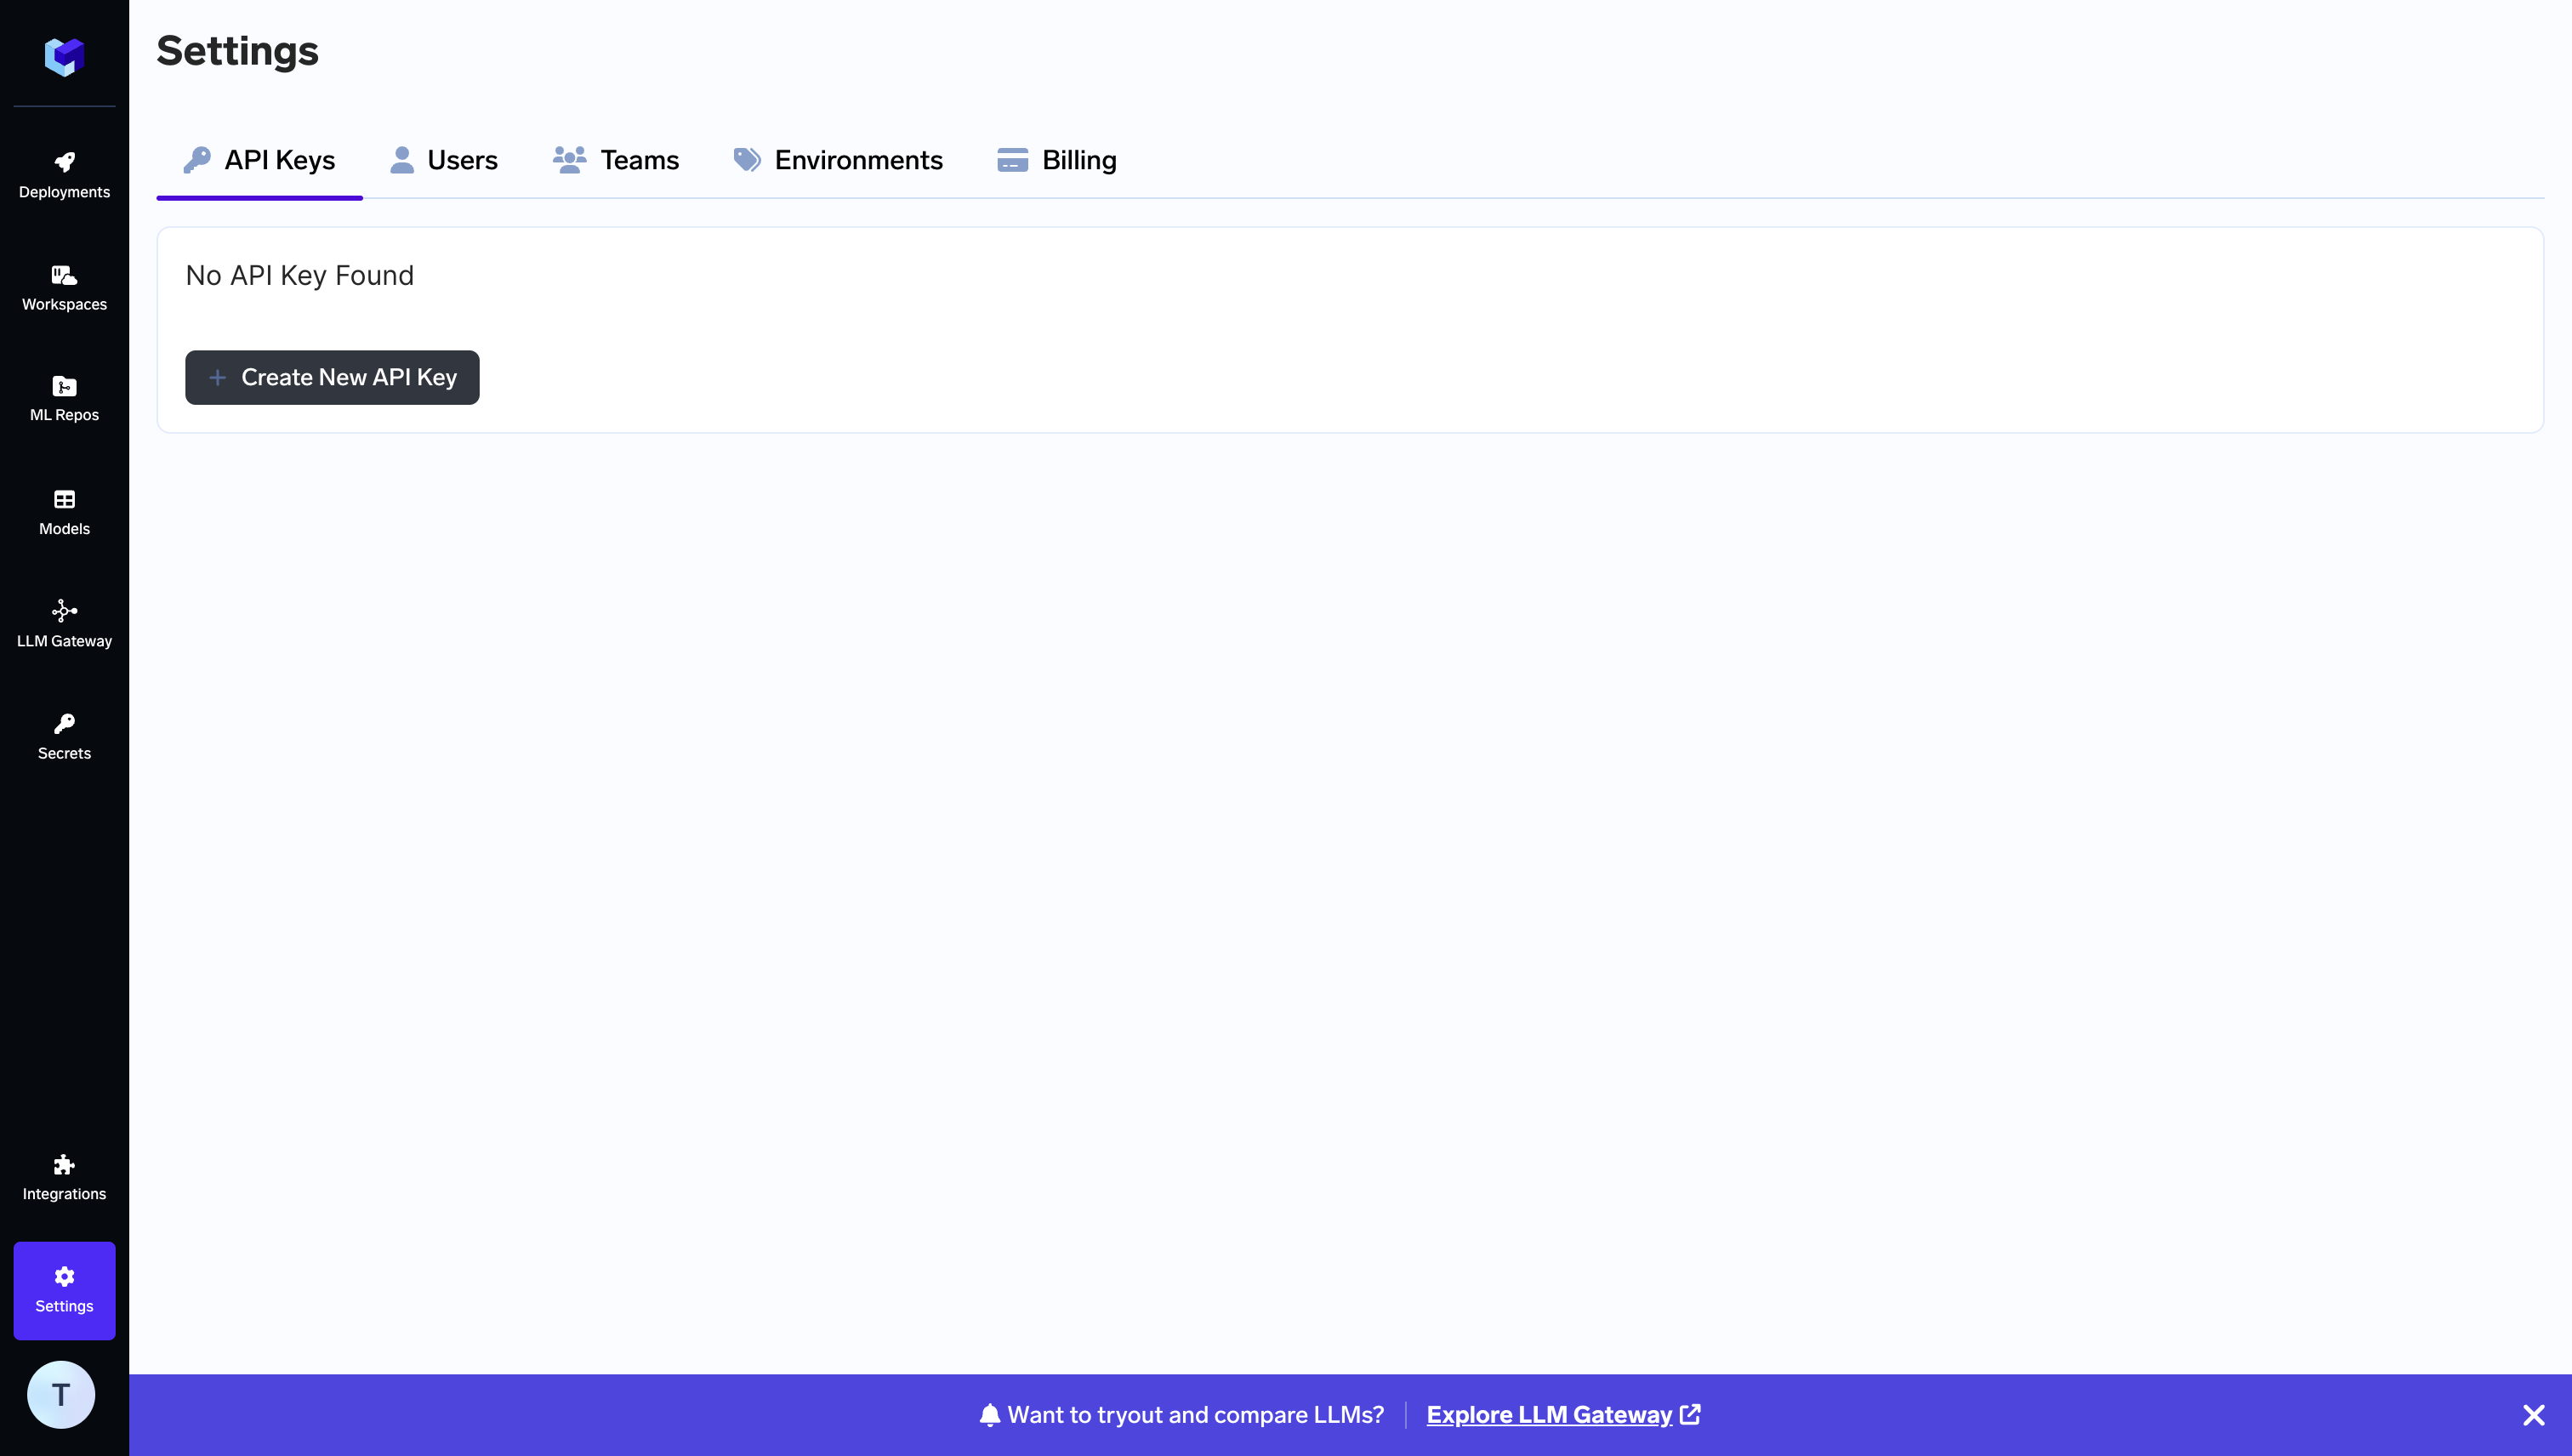

#### Using the deployed LLM

> Replace `LLM_ENDPOINT` with the model accessible to you

In [ ]:
from langchain_community.llms import OpenAI

TFY_API_KEY = "<YOUR_TFY_API_KEY>"

llm = OpenAI(
    model="truefoundry-public/Llama-2(70B)",
    temperature=0.7,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=0,
    presence_penalty=0,
    streaming=False,
    api_key=TFY_API_KEY,
    base_url="https://llm-gateway.truefoundry.com/openai"
)

In [ ]:
print(llm("Give me 3 tips to be healthy "))

### Prompt Templates

Prompt templates define the main instruction for the question answering task as well as how the fetched relevant chunks will be formatted while providing them as context to the LLM. Langchain already comes with predefined prompts for Question Answering, but we find it is always better to define your own templates to infuse any general context specific to your use case

In the following cell we define a template for single document as well the whole input context. 

In [ ]:
from langchain.prompts.prompt import PromptTemplate


DOCUMENT_PROMPT_TEMPLATE = """<document>
{page_content}
</document>"""

QA_PROMPT_TEMPLATE = """Given a list of documents, answer the given question precisely and accurately. Copying from the list of documents to form an answer is encouraged. Answer only from the information found in the  documents. Paraphrasing is allowed but do not change any of the facts. Once you answer the question, stop immediately. If the given documents do not contain a relevant answer, say "I am not sure" and stop. Do not make up an answer.

DOCUMENTS:
{context}

QUESTION:
{question}

ANSWER:
"""

document_prompt = PromptTemplate(input_variables=["page_content"], template=DOCUMENT_PROMPT_TEMPLATE)
qa_prompt = PromptTemplate(input_variables=["context", "question"], template=QA_PROMPT_TEMPLATE)

Let's look at a formatting example how langchain does it internally

In [ ]:
print(
    qa_prompt.format(
        context="\n".join([
            document_prompt.format(page_content=chunks[1].page_content),
            document_prompt.format(page_content=chunks[2].page_content),
            document_prompt.format(page_content=chunks[3].page_content),
        ]),
        question="What the report say?"
    )
)


## 5. Setting up the Query Flow

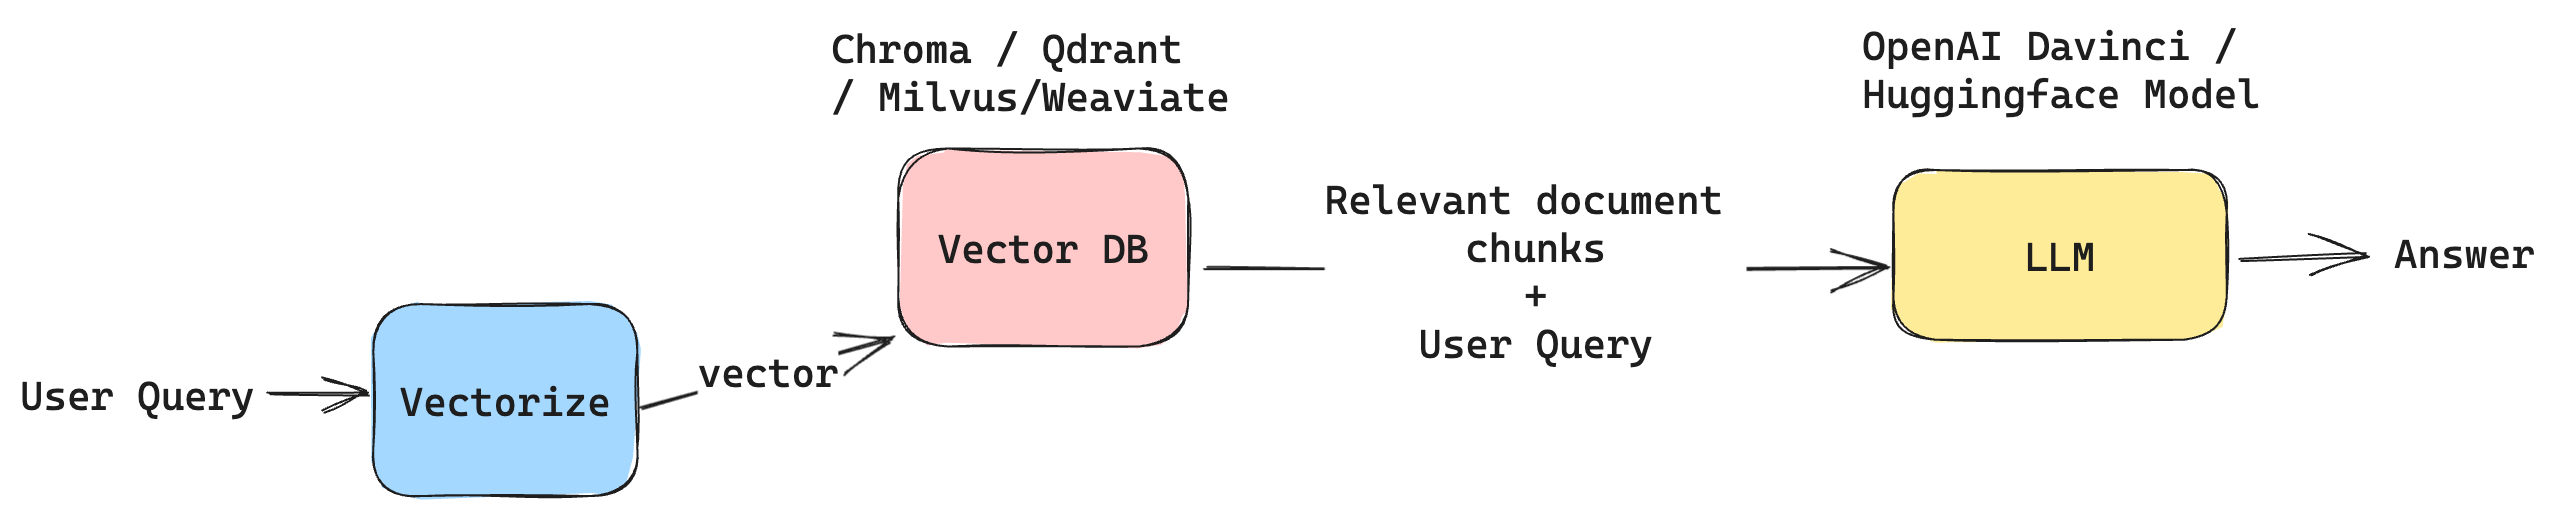

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chains.question_answering import load_qa_chain


TOP_K = 3
def do_qa(query, top_k=TOP_K, filters=None):
    search_kwargs = {"k": top_k}
    if filters:
        search_kwargs["filter"] = filters
    retriever = vector_db.as_retriever(search_type="similarity", search_kwargs=search_kwargs)
    qa = RetrievalQA(
        combine_documents_chain=load_qa_chain(
            llm=llm,
            chain_type="stuff",
            prompt=qa_prompt,
            document_variable_name="context",
            document_prompt=document_prompt,
            verbose=True,
        ),
        retriever=retriever,
        return_source_documents=True,
    )
    outputs = qa({"query": query})
    answer = outputs["result"]
    sources = outputs.get("source_documents") or []
    print("=" * 100)
    print(answer)
    print("=" * 100)
    for doc in sources:
        print("Source File:", doc.metadata['source'])
        print("Page Number:", doc.metadata['page'])
        print("Content:", doc.page_content)
        print("-" * 100)

In [ ]:
do_qa("What are the challenges with implementing LLMOps?", top_k=3)

In [ ]:
do_qa("What are some challenges with serving latency?", top_k=5)

### Passing filters

Now we will repeat the same query as above, but this time we will pass a filter that does not match `llmops_report.pdf`. We should see in the prompt and output sources that any chunk from that file is not included now. Please refer to [ChromaDB Filters](https://docs.trychroma.com/usage-guide#using-where-filters) documentation.

In [ ]:
do_qa(
    "What are some challenges with serving latency?",
    top_k=5,
    filters={"topic": {"$eq": "mlops"}}
)

## ---

## Appendix

### Querying the Vector DB directly

In [ ]:
# Create `embedder` as before and and create/load the vector_db as before
import pandas as pd

data = vector_db._collection.query(
    query_embeddings=[embedder.embed_query("This is a test!")],
    n_results=10,
)
pd.DataFrame({k: v[0] for k, v in data.items() if v})

### Running Embedding Model locally

You can replace the `Using Embedding Model from Model Catalogue` with the following code

In [ ]:
import numpy as np
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

embedder = HuggingFaceEmbeddings(model_name="intfloat/e5-small-v2")
np.array(embedder.embed_documents(["This is a test", "This is yet another test"])).shape

### Running Large Language Model locally
You can replace the `Using LLM from Model Catalogue` with the following code

In [ ]:
import torch
from langchain.llms import HuggingFacePipeline
from transformers.utils.import_utils import is_torch_bf16_available

MODEL_ID = "databricks/dolly-v2-3b"
# Uncomment the following line to use a small model for testing purposes
# MODEL_ID = "EleutherAI/pythia-70m"

llm = HuggingFacePipeline.from_model_id(
    task="text-generation",
    model_id=MODEL_ID,
    model_kwargs={
        "torch_dtype": torch.bfloat16,
        "device_map": "balanced",
        "trust_remote_code": True,
    },
    pipeline_kwargs={
        "do_sample": True,
        "temperature": 0.7,
        "top_k": 1000,
        "top_p": 0.9,
        "max_new_tokens": 350,
    }
)
print(llm("Give me 3 tips to be healthy "))